In [ ]:
!pip install pennylane
!pip install pennylane-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.9 MB/s eta 0:00:00


# 1. Project Setup

In [ ]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

# ML imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                          roc_auc_score, f1_score, balanced_accuracy_score, roc_curve,
                          precision_recall_curve, average_precision_score)
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

# Quantum imports
import pennylane as qml
from pennylane.templates import AngleEmbedding, AmplitudeEmbedding
from itertools import combinations

# Set visual style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set display options
pd.set_option('display.max_columns', None)

# 2. Enhanced Data Loading and Exploration

Loading dataset...


<ipython-input-4-6037faaafb35>:16: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


Dataset loaded with 218,816 rows and 41 columns
Number of unique patients: 15,912

Adherence Score Statistics:
   Mean: 6.43
   Median: 7.00
   Min: 1.00
   Max: 12.00
   Std Dev: 3.94


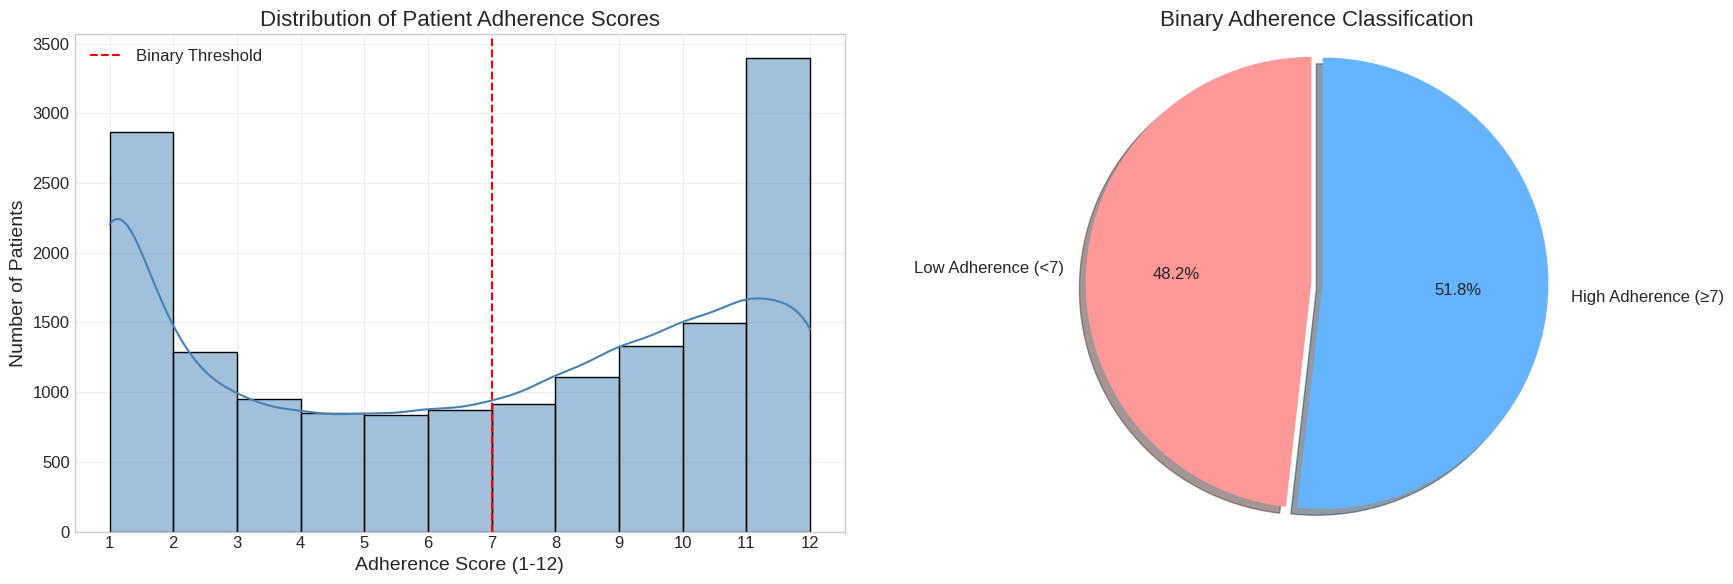

In [ ]:
def load_and_preprocess_data(filepath):
    """
    Load and preprocess the hypertension dataset.

    Parameters:
    -----------
    filepath : str
        Path to the dataset CSV file

    Returns:
    --------
    df : pandas DataFrame
        Preprocessed DataFrame with converted datatypes and cleaned columns
    """
    print("Loading dataset...")
    df = pd.read_csv(filepath)

    # Clean column names
    df.columns = [col.strip() for col in df.columns]

    # Convert date columns to datetime
    date_columns = ['SERVICE DATE', 'ASSESS DATE', 'DATE RECEIVED', 'BIRTHDATE']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], format='%d/%m/%Y', errors='coerce')

    # Convert numeric columns
    numeric_cols = ['AMOUNT CLAIMED', 'PAID FROM RISK AMT', 'TOTAL AMOUNT PAID',
                   'ADHERENCE', 'CURRENT AGE']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

# Load the hypertension adherence dataset
filepath = '/content/HTN Adherence Data.csv'
df = load_and_preprocess_data(filepath)

print(f"Dataset loaded with {df.shape[0]:,} rows and {df.shape[1]} columns")
print(f"Number of unique patients: {df['MEMBER'].nunique():,}")

# Basic statistics about adherence scores
adherence_stats = df.groupby('MEMBER')['ADHERENCE'].first().describe()
print("\nAdherence Score Statistics:")
print(f"   Mean: {adherence_stats['mean']:.2f}")
print(f"   Median: {adherence_stats['50%']:.2f}")
print(f"   Min: {adherence_stats['min']:.2f}")
print(f"   Max: {adherence_stats['max']:.2f}")
print(f"   Std Dev: {adherence_stats['std']:.2f}")

# Create interactive adherence score visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Distribution of adherence scores
member_adherence = df.groupby('MEMBER')['ADHERENCE'].first()
sns.histplot(member_adherence, bins=range(1, 13), kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Distribution of Patient Adherence Scores')
axes[0].set_xlabel('Adherence Score (1-12)')
axes[0].set_ylabel('Number of Patients')
axes[0].set_xticks(range(1, 13))
axes[0].grid(True, alpha=0.3)

# Add vertical line at threshold value (7)
axes[0].axvline(x=7, color='red', linestyle='--', label='Binary Threshold')
axes[0].legend()

# Pie chart of binary adherence categories
binary_counts = (member_adherence >= 7).value_counts()
axes[1].pie([binary_counts[False], binary_counts[True]],
        labels=['Low Adherence (<7)', 'High Adherence (≥7)'],
        autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff'],
        explode=(0.05, 0),
        shadow=True,
        startangle=90)
axes[1].axis('equal')
axes[1].set_title('Binary Adherence Classification')

plt.tight_layout()
plt.show()

# 3. Enhanced Patient Feature Engineering

Creating patient-level features...


<ipython-input-5-c19dd208e33a>:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_df[f'TAKES_{med_class.upper()}'] = patient_groups.apply(
<ipython-input-5-c19dd208e33a>:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_df[f'TAKES_{med_class.upper()}'] = patient_groups.apply(
<ipython-input-5-c19dd208e33a>:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This b

Created patient-level dataset with 15,912 patients and 29 features

Adherence binary distribution (%):
Low (class 0): 48.2%
High (class 1): 51.8%


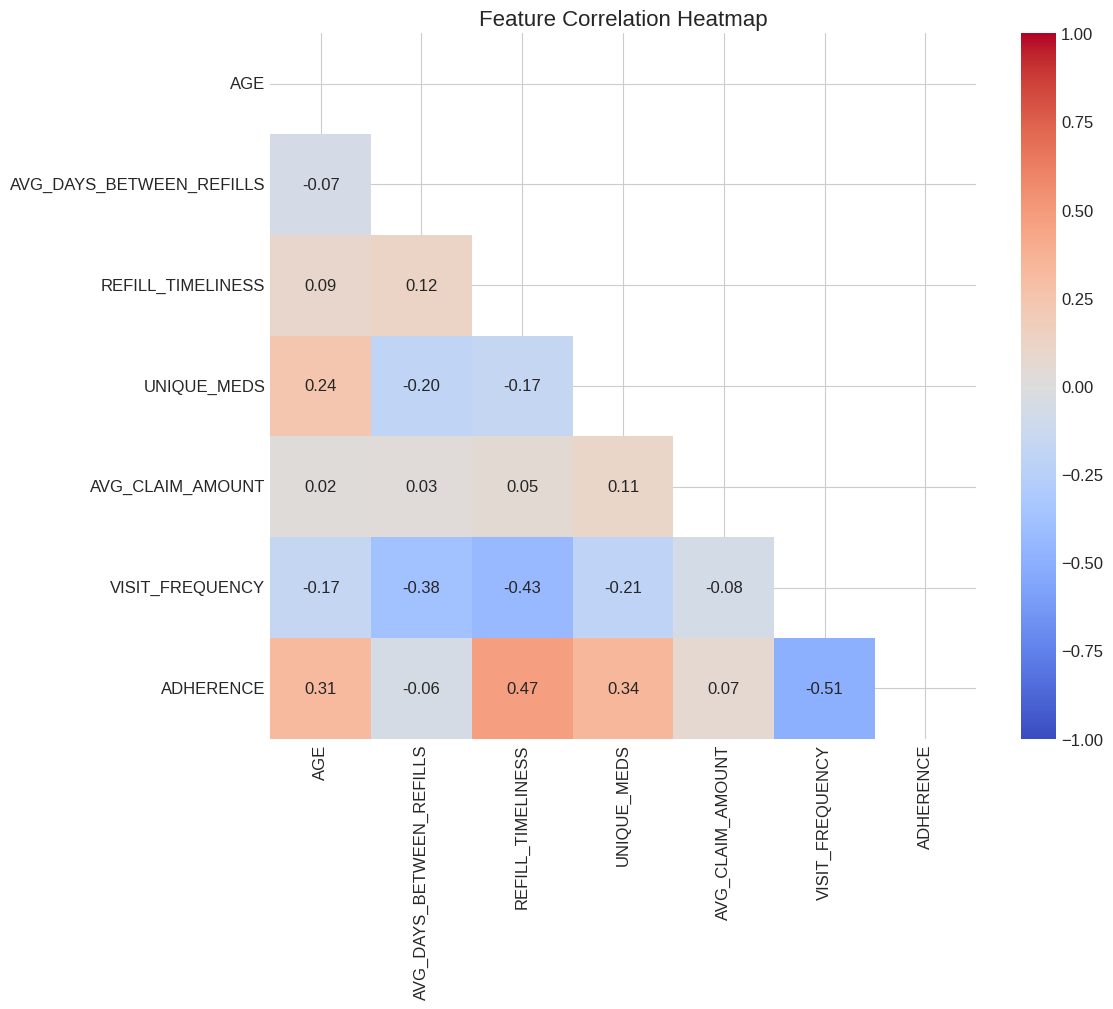

In [ ]:
def create_patient_features(df):
    """
    Create comprehensive patient-level features from transactional data.

    Parameters:
    -----------
    df : pandas DataFrame
        Original transaction-level data

    Returns:
    --------
    patient_df : pandas DataFrame
        Patient-level dataset with engineered features
    """
    print("Creating patient-level features...")

    # Group by patient
    patient_groups = df.groupby('MEMBER')

    # Basic demographic and adherence info
    patient_df = patient_groups.agg({
        'ADHERENCE': 'first',
        'GENDER': 'first',
        'CURRENT AGE': 'first',
        'OPTION NAME': 'first'
    }).rename(columns={'CURRENT AGE': 'AGE'})

    # Create age groups for better stratification
    age_bins = [0, 30, 40, 50, 60, 70, 80, 100]
    age_labels = ['<30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']
    patient_df['AGE_GROUP'] = pd.cut(patient_df['AGE'], bins=age_bins, labels=age_labels)

    # Medical characteristics
    patient_df['UNIQUE_MEDS'] = patient_groups['CODE DESCRIPTION'].nunique()

    # Classify medications for hypertension - enhanced with more specific categories
    def classify_medication(description):
        if pd.isna(description):
            return 'Unknown'

        description = description.upper()

        # ACE Inhibitors
        if any(x in description for x in ['ENALAPRIL', 'LISINOPRIL', 'RAMIPRIL', 'PERINDOPRIL',
                                         'CAPTOPRIL', 'QUINAPRIL', 'TRANDOLAPRIL']):
            return 'ACE_Inhibitor'

        # Angiotensin II Receptor Blockers (ARBs)
        elif any(x in description for x in ['LOSARTAN', 'VALSARTAN', 'CANDESARTAN', 'IRBESARTAN',
                                           'TELMISARTAN', 'OLMESARTAN', 'EPROSARTAN']):
            return 'ARB'

        # Calcium Channel Blockers (CCBs)
        elif any(x in description for x in ['AMLODIPINE', 'NIFEDIPINE', 'FELODIPINE', 'DILTIAZEM',
                                           'VERAPAMIL', 'NIMODIPINE']):
            return 'CCB'

        # Diuretics
        elif any(x in description for x in ['HYDROCHLOROTHIAZIDE', 'CHLORTHALIDONE', 'INDAPAMIDE',
                                          'FUROSEMIDE', 'FRUSEMIDE', 'SPIRONOLACTONE']):
            return 'Diuretic'

        # Beta Blockers
        elif any(x in description for x in ['ATENOLOL', 'METOPROLOL', 'BISOPROLOL', 'CARVEDILOL',
                                          'NEBIVOLOL', 'SOTALOL']):
            return 'Beta_Blocker'

        # Combination Drugs
        elif any(x in description for x in ['TENORIC', 'EXFORGE', 'CO-DIOVAN', 'ZIAK']):
            return 'Combination'

        else:
            return 'Other'

    df['MED_CLASS'] = df['CODE DESCRIPTION'].apply(classify_medication)

    # Create medication class indicators
    med_classes = ['ACE_Inhibitor', 'ARB', 'CCB', 'Diuretic', 'Beta_Blocker', 'Combination', 'Other']
    for med_class in med_classes:
        patient_df[f'TAKES_{med_class.upper()}'] = patient_groups.apply(
            lambda x: int((x['MED_CLASS'] == med_class).any())).values

    # Calculate financial patterns
    patient_df['AVG_CLAIM_AMOUNT'] = patient_groups['AMOUNT CLAIMED'].mean()
    patient_df['TOTAL_CLAIM_AMOUNT'] = patient_groups['AMOUNT CLAIMED'].sum()
    patient_df['NUM_CLAIMS'] = patient_groups.size()
    patient_df['AVG_UNITS'] = patient_groups['UNITS'].mean()

    # Calculate refill patterns
    def get_refill_stats(group):
        if len(group) <= 1:
            return pd.Series({
                'AVG_DAYS_BETWEEN_REFILLS': 0,
                'MAX_GAP': 0,
                'REFILL_REGULARITY': 0,
                'REFILL_TIMELINESS': 0
            })

        # Sort by date and calculate days between refills
        sorted_dates = group['SERVICE DATE'].sort_values()
        days_between = (sorted_dates.diff().dt.days.dropna())

        if len(days_between) == 0:
            return pd.Series({
                'AVG_DAYS_BETWEEN_REFILLS': 0,
                'MAX_GAP': 0,
                'REFILL_REGULARITY': 0,
                'REFILL_TIMELINESS': 0
            })

        avg_gap = days_between.mean()
        max_gap = days_between.max()

        # Coefficient of variation for regularity (lower is better)
        regularity = days_between.std() / avg_gap if avg_gap > 0 else 0

        # Timeliness score: percentage of refills within the expected window (30±7 days)
        on_time_refills = ((days_between >= 23) & (days_between <= 37)).mean()

        return pd.Series({
            'AVG_DAYS_BETWEEN_REFILLS': avg_gap,
            'MAX_GAP': max_gap,
            'REFILL_REGULARITY': regularity,
            'REFILL_TIMELINESS': on_time_refills
        })

    refill_stats = patient_groups.apply(get_refill_stats)
    patient_df = pd.concat([patient_df, refill_stats], axis=1)

    # Add visit frequency features
    patient_df['FIRST_VISIT'] = patient_groups['SERVICE DATE'].min()
    patient_df['LAST_VISIT'] = patient_groups['SERVICE DATE'].max()
    patient_df['OBSERVATION_PERIOD_DAYS'] = (patient_df['LAST_VISIT'] - patient_df['FIRST_VISIT']).dt.days
    patient_df['VISIT_FREQUENCY'] = patient_df['NUM_CLAIMS'] / (patient_df['OBSERVATION_PERIOD_DAYS'] + 1) * 30  # Visits per month

    # Add healthcare plan information
    plan_types = {
        'BASICARE': {'TYPE': 'STANDARD', 'COST': 'LOW'},
        'ICARE': {'TYPE': 'STANDARD', 'COST': 'MEDIUM'},
        'STUDYMATE PRIVATE': {'TYPE': 'SPECIAL', 'COST': 'LOW'},
        'PRIVATE HOSPITAL': {'TYPE': 'PREMIUM', 'COST': 'HIGH'},
        'PRIVATE HOSPITAL PLUS': {'TYPE': 'PREMIUM', 'COST': 'HIGH'}
    }

    patient_df['PLAN_TYPE'] = patient_df['OPTION NAME'].map(lambda x: plan_types.get(x, {}).get('TYPE', 'STANDARD'))
    patient_df['PLAN_COST'] = patient_df['OPTION NAME'].map(lambda x: plan_types.get(x, {}).get('COST', 'MEDIUM'))

    # Create binary adherence - 7+ is considered adherent
    patient_df['ADHERENCE_BINARY'] = (patient_df['ADHERENCE'] >= 7).astype(int)

    # Convert to -1 and 1 for SVM
    patient_df['ADHERENCE_SVM'] = 2 * patient_df['ADHERENCE_BINARY'] - 1

    # Fill missing values
    numeric_cols = patient_df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        patient_df[col] = patient_df[col].fillna(patient_df[col].median())

    return patient_df

# Create patient-level dataset
patient_df = create_patient_features(df)
print(f"Created patient-level dataset with {patient_df.shape[0]:,} patients and {patient_df.shape[1]} features")

# Check class distribution for binary adherence
adherence_counts = patient_df['ADHERENCE_BINARY'].value_counts(normalize=True) * 100
print("\nAdherence binary distribution (%):")
for category, percentage in sorted(adherence_counts.items()):
    label = ["Low", "High"][category]
    print(f"{label} (class {category}): {percentage:.1f}%")

# Enhanced feature visualization
plt.figure(figsize=(12, 10))

# Select top features for visualization
top_features = ['AGE', 'AVG_DAYS_BETWEEN_REFILLS', 'REFILL_TIMELINESS',
                'UNIQUE_MEDS', 'AVG_CLAIM_AMOUNT', 'VISIT_FREQUENCY']

# Create correlation plot for selected features
feat_corr = patient_df[top_features + ['ADHERENCE']].corr()
mask = np.triu(np.ones_like(feat_corr, dtype=bool))
sns.heatmap(feat_corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1,
            annot=True, square=True, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

#4. Enhanced Feature Preparation

Preparing features for classification...
Numeric features: 12
Categorical features: 4
Binary features: 7
Date features: 2
Training set size: 11,934, Test set size: 3,978
Preprocessed data shape: (11934, 37)
PCA explained variance: 0.9444


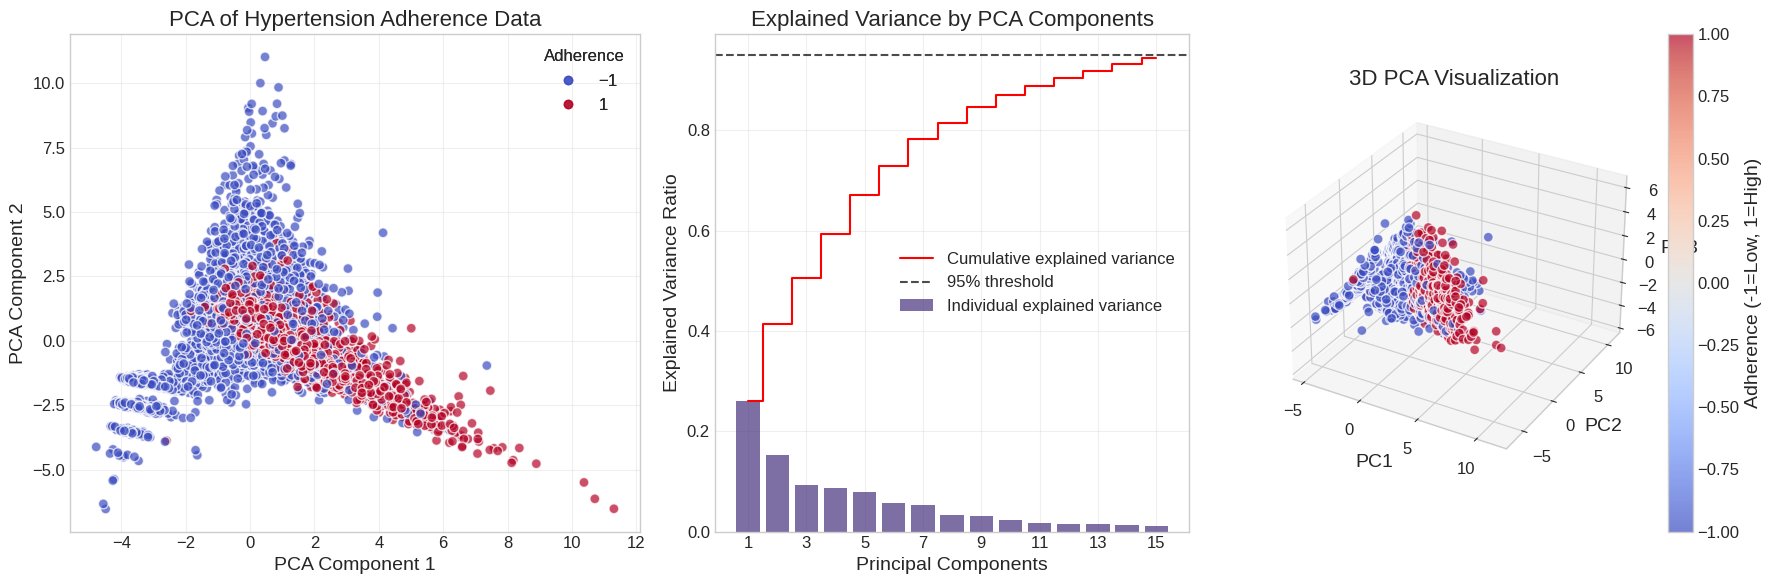

PCA data shape: (11934, 15)


In [ ]:
# Prepare data for binary classification with enhanced feature selection
def prepare_features(patient_df):
    """
    Prepare features for binary classification with enhanced selection.

    Parameters:
    -----------
    patient_df : pandas DataFrame
        Patient-level dataset

    Returns:
    --------
    X : pandas DataFrame
        Feature matrix
    y : pandas Series
        Target variable
    feature_types : dict
        Dictionary containing lists of different feature types
    """
    print("Preparing features for classification...")

    # Remove direct adherence scores from features
    X = patient_df.drop(['ADHERENCE', 'ADHERENCE_BINARY', 'ADHERENCE_SVM'], axis=1)
    y = patient_df['ADHERENCE_SVM']  # Using -1, 1 labels for SVM

    # Identify feature types
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    # Boolean features (keeping as numeric)
    binary_features = [col for col in numeric_features if col.startswith('TAKES_')]

    # Remove binary features from numeric features list to handle them separately
    numeric_features = [col for col in numeric_features if col not in binary_features]

    # Remove date features from numeric features
    date_features = [col for col in X.columns if pd.api.types.is_datetime64_dtype(X[col])]
    numeric_features = [col for col in numeric_features if col not in date_features]

    feature_types = {
        'numeric': numeric_features,
        'categorical': categorical_features,
        'binary': binary_features,
        'date': date_features
    }

    return X, y, feature_types

X, y, feature_types = prepare_features(patient_df)

# Print feature information
print(f"Numeric features: {len(feature_types['numeric'])}")
print(f"Categorical features: {len(feature_types['categorical'])}")
print(f"Binary features: {len(feature_types['binary'])}")
print(f"Date features: {len(feature_types['date'])}")

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]:,}, Test set size: {X_test.shape[0]:,}")

# Create preprocessing pipeline for features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, feature_types['numeric']),
        ('cat', categorical_transformer, feature_types['categorical']),
        ('bin', binary_transformer, feature_types['binary'])
    ],
    remainder='drop'  # Drop any columns not specified
)

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print(f"Preprocessed data shape: {X_train_preprocessed.shape}")

# Enhanced PCA visualization
def apply_pca_and_visualize(X_train_preprocessed, X_test_preprocessed, y_train, y_test, n_components=15):
    """
    Apply PCA and visualize the results with enhanced plots.

    Parameters:
    -----------
    X_train_preprocessed : numpy array
        Preprocessed training features
    X_test_preprocessed : numpy array
        Preprocessed test features
    y_train : numpy array
        Training labels
    y_test : numpy array
        Test labels
    n_components : int
        Number of PCA components to retain

    Returns:
    --------
    X_train_normalized : numpy array
        Normalized training data for quantum processing
    X_test_normalized : numpy array
        Normalized test data for quantum processing
    """
    # For quantum processing, reduce dimensions with PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_preprocessed)
    X_test_pca = pca.transform(X_test_preprocessed)

    # Normalize to [0, 1] range for quantum encoding
    X_train_normalized = (X_train_pca - X_train_pca.min(axis=0)) / (X_train_pca.max(axis=0) - X_train_pca.min(axis=0))
    X_test_normalized = (X_test_pca - X_train_pca.min(axis=0)) / (X_train_pca.max(axis=0) - X_train_pca.min(axis=0))

    # Handle potential NaN values
    X_train_normalized = np.nan_to_num(X_train_normalized)
    X_test_normalized = np.nan_to_num(X_test_normalized)

    print(f"PCA explained variance: {sum(pca.explained_variance_ratio_):.4f}")

    # Enhanced PCA visualization
    fig = plt.figure(figsize=(18, 6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1.2, 1, 1])

    # Plot 1: First two PCA components with class separation
    ax1 = plt.subplot(gs[0])
    scatter = ax1.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train,
                      cmap='coolwarm', alpha=0.7, s=50, edgecolors='w')
    ax1.set_title('PCA of Hypertension Adherence Data')
    ax1.set_xlabel('PCA Component 1')
    ax1.set_ylabel('PCA Component 2')
    legend1 = ax1.legend(*scatter.legend_elements(),
                    loc="upper right", title="Adherence")
    ax1.add_artist(legend1)
    ax1.grid(alpha=0.3)

    # Plot 2: Explained variance by component
    ax2 = plt.subplot(gs[1])
    variance_explained = pca.explained_variance_ratio_
    cum_variance = np.cumsum(variance_explained)
    ax2.bar(range(1, len(variance_explained) + 1), variance_explained,
           alpha=0.7, align='center', label='Individual explained variance')
    ax2.step(range(1, len(cum_variance) + 1), cum_variance, where='mid',
            label='Cumulative explained variance', color='red')
    ax2.axhline(y=0.95, color='k', linestyle='--', alpha=0.7, label='95% threshold')
    ax2.set_title('Explained Variance by PCA Components')
    ax2.set_xlabel('Principal Components')
    ax2.set_ylabel('Explained Variance Ratio')
    ax2.set_xticks(range(1, len(variance_explained) + 1, 2))
    ax2.legend(loc='best')
    ax2.grid(alpha=0.3)

    # Plot 3: 3D visualization of first three components
    ax3 = plt.subplot(gs[2], projection='3d')
    p = ax3.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2],
                   c=y_train, cmap='coolwarm', alpha=0.7, s=50, edgecolors='w')
    ax3.set_title('3D PCA Visualization')
    ax3.set_xlabel('PC1')
    ax3.set_ylabel('PC2')
    ax3.set_zlabel('PC3')
    fig.colorbar(p, ax=ax3, label='Adherence (-1=Low, 1=High)')

    plt.tight_layout()
    plt.show()

    return X_train_normalized, X_test_normalized, pca

# Apply PCA and visualize
X_train_normalized, X_test_normalized, pca = apply_pca_and_visualize(
    X_train_preprocessed, X_test_preprocessed, y_train, y_test, n_components=15
)
print(f"PCA data shape: {X_train_normalized.shape}")

# Convert to torch tensors for efficient quantum kernel computation
X_train_torch = torch.tensor(X_train_normalized, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_normalized, dtype=torch.float32)

# 5. Enhanced Quantum Model Setup

Setting up quantum device with 15 qubits...
Visualizing quantum circuits...


<ipython-input-7-5dc8f8c67bb1>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


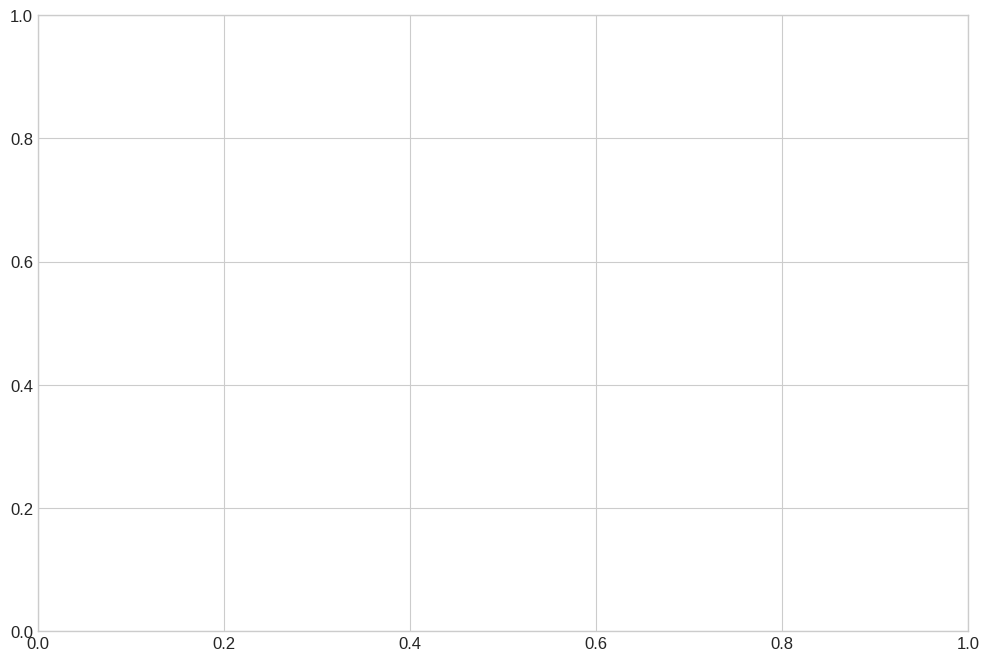

<ipython-input-7-5dc8f8c67bb1>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


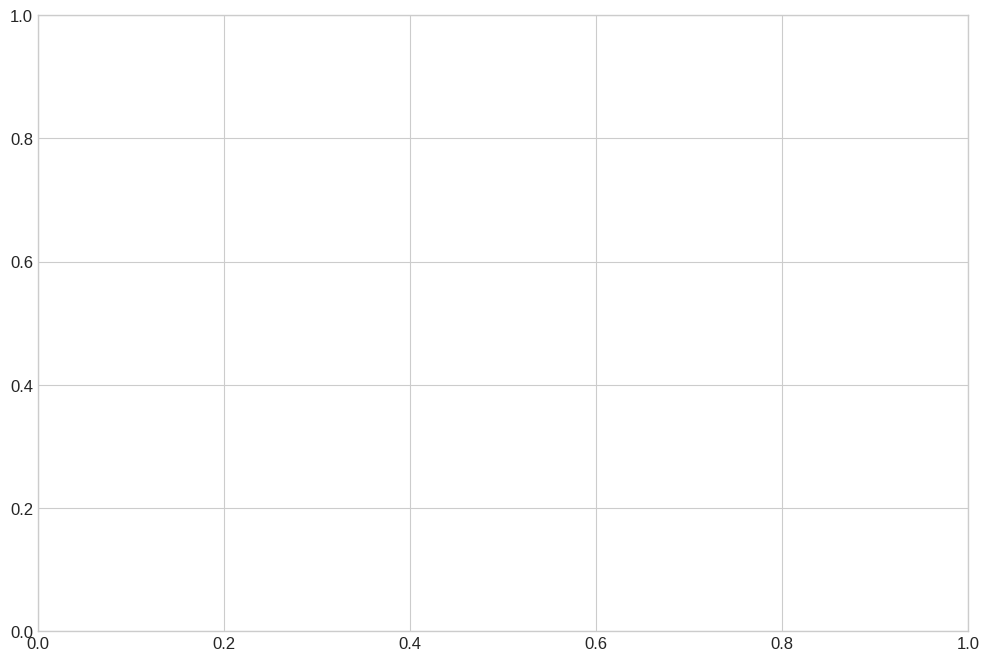

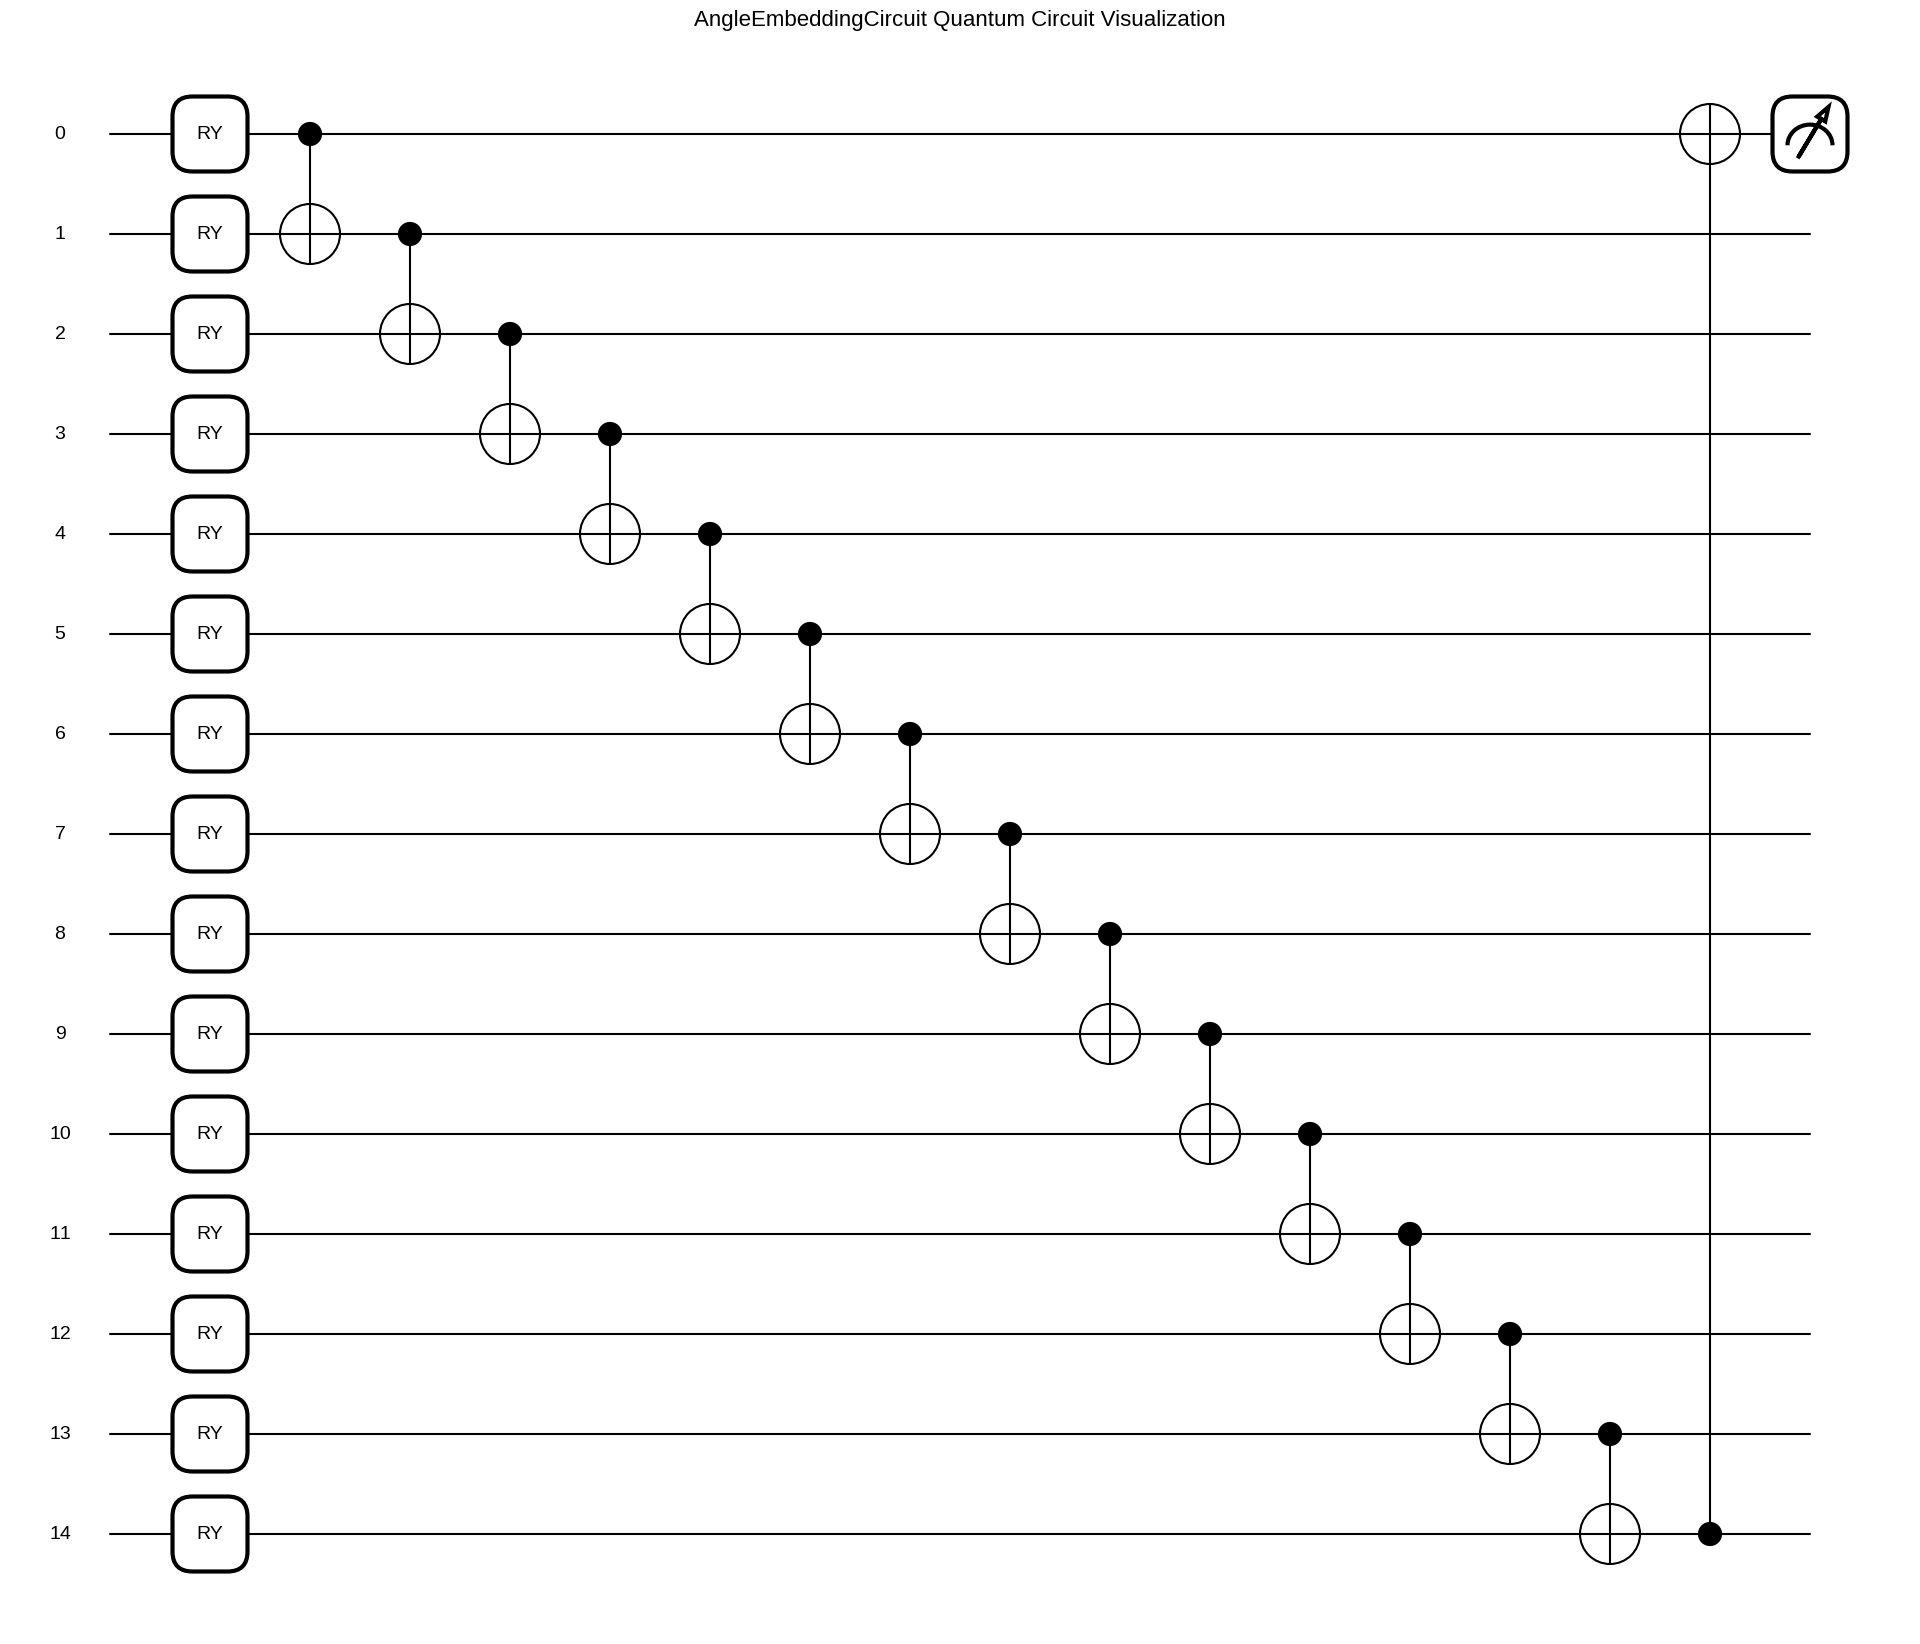

In [ ]:
# Initialize the quantum device with additional information
n_qubits = 15
print(f"Setting up quantum device with {n_qubits} qubits...")
dev = qml.device("lightning.qubit", wires=n_qubits)

def visualize_quantum_circuit(circuit_function, n_qubits, sample_data):
    """
    Visualize a quantum circuit using PennyLane's draw feature.

    Parameters:
    -----------
    circuit_function : function
        The quantum circuit function to visualize
    n_qubits : int
        Number of qubits
    sample_data : array
        Sample data point to encode
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Create a temporary circuit for visualization
    @qml.qnode(dev)
    def temp_circuit(x):
        circuit_function(n_qubits, x)
        return qml.expval(qml.PauliZ(0))

    # Draw the circuit
    circuit = qml.draw_mpl(temp_circuit)(sample_data)

    plt.title(f"{circuit_function.__name__} Quantum Circuit Visualization")
    plt.tight_layout()
    plt.show()

# Define ZZ Feature Map with improved entanglement
def ZZFeatureMap(nqubits, data, reps=2):
    """
    Implements an enhanced ZZ Feature Map with multiple repetitions for
    increased expressivity.

    Args:
        nqubits: Number of qubits
        data: Classical data vector to be encoded
        reps: Number of repetitions of the feature map
    """
    # Number of variables to load
    nload = min(len(data), nqubits)

    for r in range(reps):
        # First layer: Hadamard + rotation
        for i in range(nload):
            qml.Hadamard(wires=i)
            qml.RZ(2.0 * data[i], wires=i)

        # Second layer: Entangling with ZZ interactions
        for pair in list(combinations(range(nload), 2)):
            q0 = pair[0]
            q1 = pair[1]

            qml.CZ(wires=[q0, q1])
            qml.RZ(2.0 * (np.pi - data[q0]) * (np.pi - data[q1]), wires=q1)
            qml.CZ(wires=[q0, q1])

        # Add additional entangling layer if not last repetition
        if r < reps - 1:
            for i in range(0, nload-1, 2):
                if i+1 < nload:  # Ensure we don't go out of bounds
                    qml.CNOT(wires=[i, i+1])

# Define enhanced Angle Embedding circuit
def AngleEmbeddingCircuit(nqubits, data, reps=1):
    """
    Implements an enhanced Angle Embedding with multiple repetitions and
    entanglement layers for increased expressivity.

    Args:
        nqubits: Number of qubits
        data: Classical data vector to be encoded
        reps: Number of repetitions of the embedding
    """
    # Number of variables to load
    nload = min(len(data), nqubits)

    for r in range(reps):
        # Angle embedding layer
        for i in range(nload):
            qml.RY(np.pi * data[i], wires=i)

        # Entangling layer
        for i in range(nload-1):
            qml.CNOT(wires=[i, i+1])

        # Add ring entanglement if there are enough qubits
        if nload > 2:
            qml.CNOT(wires=[nload-1, 0])

# Visualize both quantum circuits with sample data
print("Visualizing quantum circuits...")
sample_data = X_train_normalized[0]
visualize_quantum_circuit(ZZFeatureMap, n_qubits, sample_data)
visualize_quantum_circuit(AngleEmbeddingCircuit, n_qubits, sample_data)

# Define ZZ Feature Map circuit
@qml.qnode(dev, interface="torch")
def zz_state_circuit(x):
    """Return quantum state after ZZ feature map embedding."""
    ZZFeatureMap(n_qubits, x)
    return qml.state()

# Define Angle Embedding circuit
@qml.qnode(dev, interface="torch")
def angle_state_circuit(x):
    """Return quantum state after angle embedding with repetitions."""
    AngleEmbeddingCircuit(n_qubits, x)
    return qml.state()

# Function to compute kernel matrices using the quantum states
def compute_kernel_matrices(circuit, X_train, X_test, name="Quantum Circuit"):
    """
    Compute training and test kernel matrices using the given quantum circuit.

    Args:
        circuit: The quantum circuit function for state preparation
        X_train: Training data as torch tensor
        X_test: Test data as torch tensor
        name: Name of the circuit for progress reporting

    Returns:
        K_train_np: Training kernel matrix as numpy array
        K_test_np: Test kernel matrix as numpy array
    """
    print(f"Computing quantum states for {name} training data...")
    states_train = []
    for x in tqdm(X_train):
        states_train.append(circuit(x))
    states_train = torch.stack(states_train)

    print(f"Computing quantum states for {name} test data...")
    states_test = []
    for x in tqdm(X_test):
        states_test.append(circuit(x))
    states_test = torch.stack(states_test)

    # Compute kernel matrices using the squared absolute value of inner products
    print("Computing kernel matrices...")
    K_train = torch.abs(states_train @ states_train.conj().transpose(0, 1)) ** 2
    K_test = torch.abs(states_test @ states_train.conj().transpose(0, 1)) ** 2

    # Convert to numpy arrays for scikit-learn
    K_train_np = K_train.detach().numpy()
    K_test_np = K_test.detach().numpy()

    return K_train_np, K_test_np

#6. Enhanced QSVM Training and Evaluation


===== Training Classical SVM for comparison =====
Best parameters: {'C': 10, 'gamma': 1}
Best cross-validation score: 0.9414
Accuracy: 0.9444
Balanced Accuracy: 0.9439
F1 Score: 0.9444
Classification Report:
              precision    recall  f1-score   support

         Low       0.96      0.93      0.94      1917
        High       0.93      0.96      0.95      2061

    accuracy                           0.94      3978
   macro avg       0.95      0.94      0.94      3978
weighted avg       0.94      0.94      0.94      3978



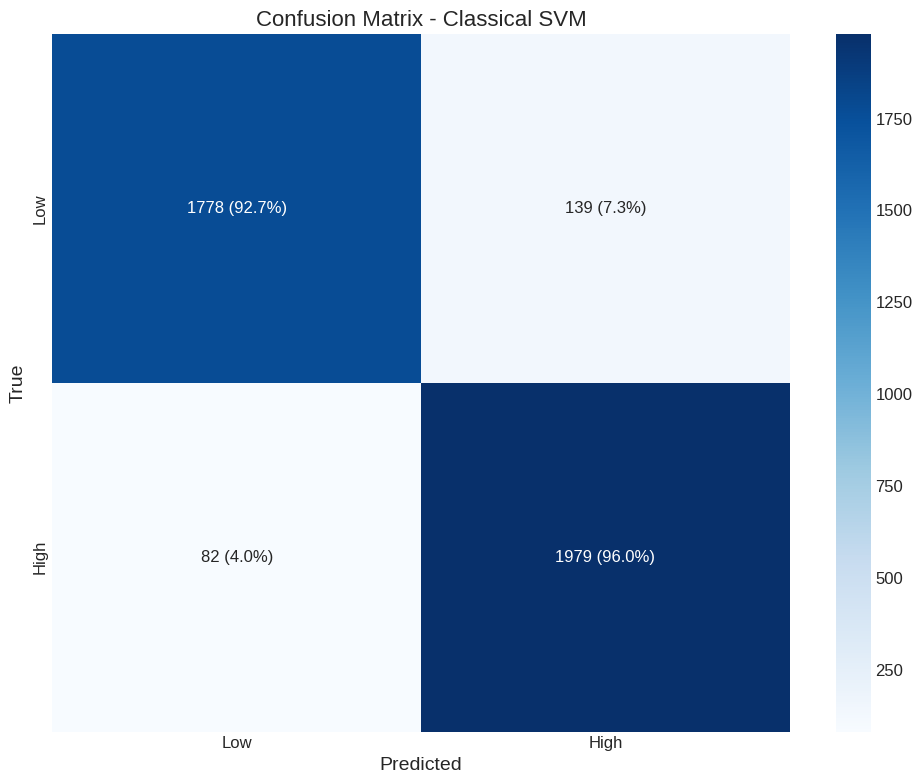

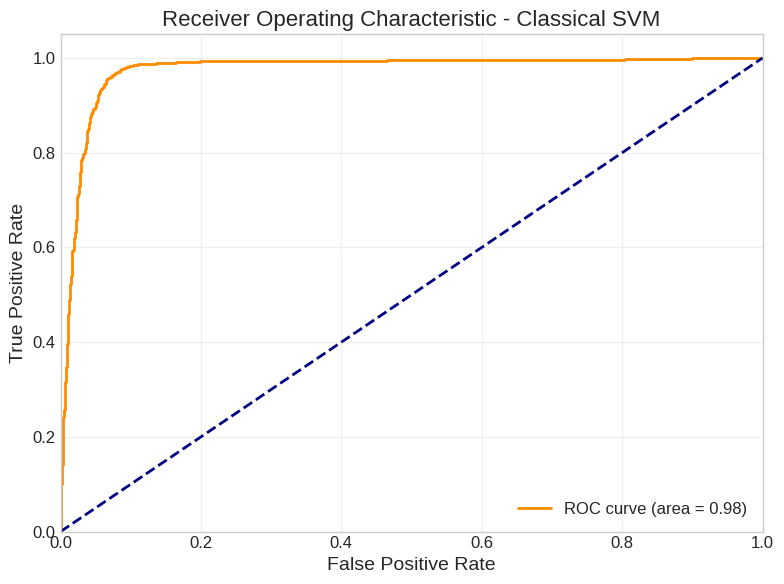

<ipython-input-8-de2f1ed2ea87>:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15),


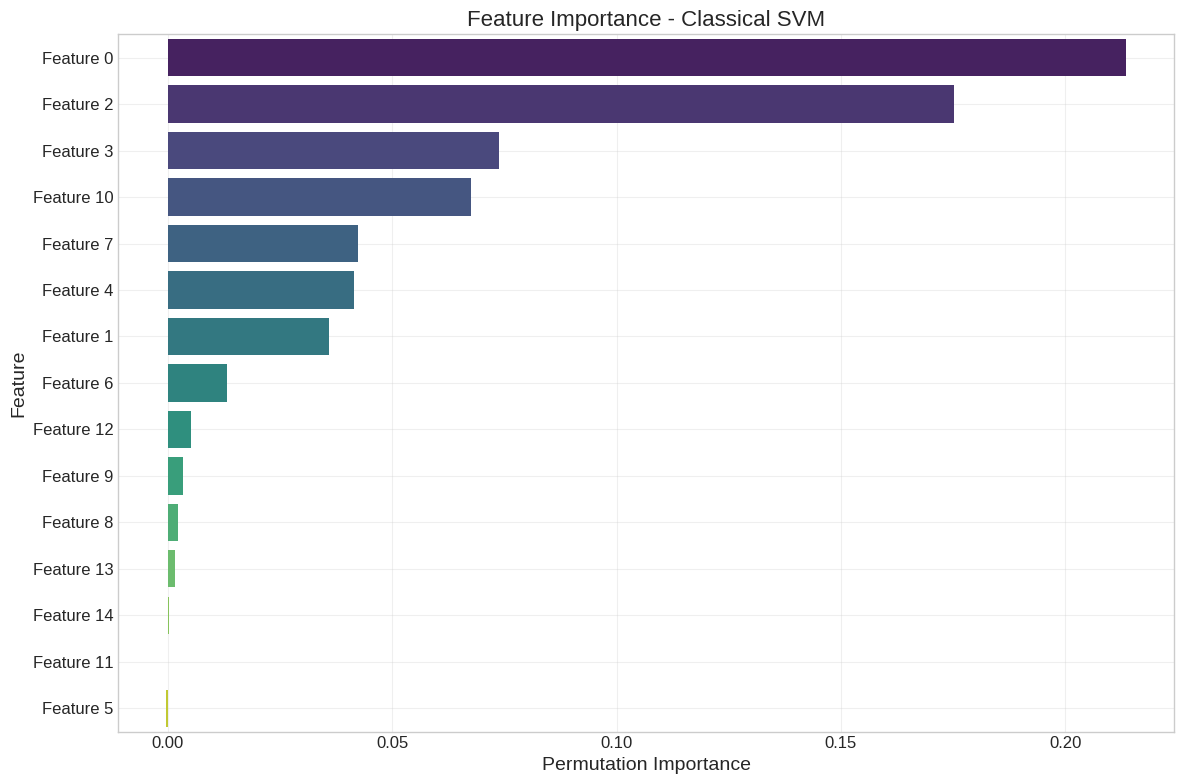


Computing kernel matrices with Angle Embedding...
Computing quantum states for Angle Embedding training data...


  0%|          | 0/11934 [00:00<?, ?it/s]

Computing quantum states for Angle Embedding test data...


  0%|          | 0/3978 [00:00<?, ?it/s]

Computing kernel matrices...

===== Training QSVM with Angle Embedding =====
Accuracy: 0.9419
Balanced Accuracy: 0.9414
F1 Score: 0.9419
Classification Report:
              precision    recall  f1-score   support

         Low       0.95      0.93      0.94      1917
        High       0.93      0.96      0.94      2061

    accuracy                           0.94      3978
   macro avg       0.94      0.94      0.94      3978
weighted avg       0.94      0.94      0.94      3978



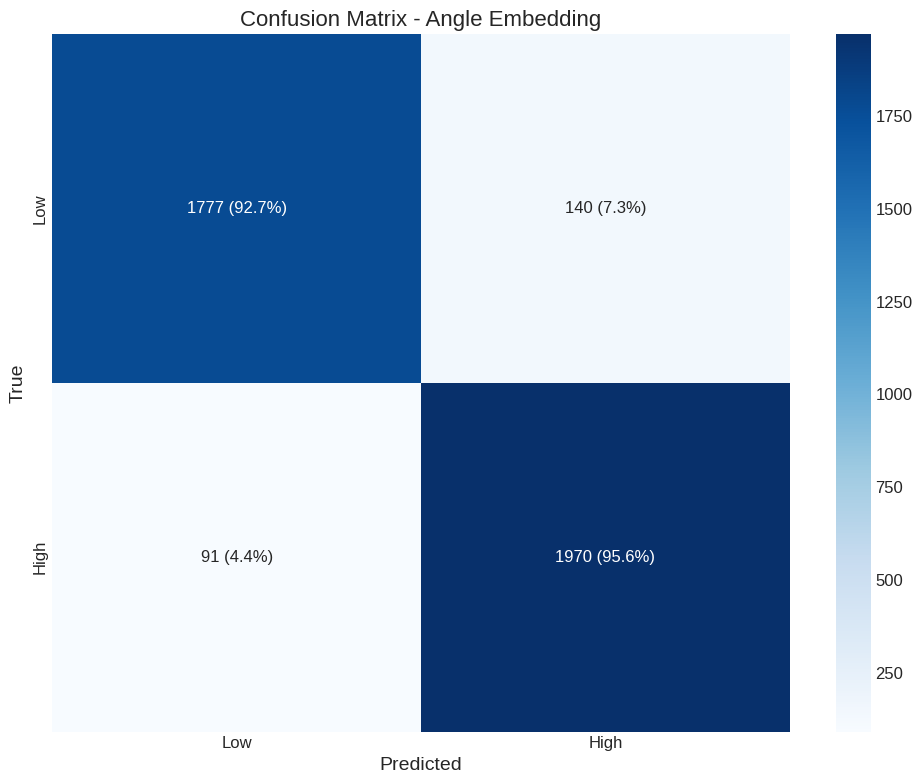

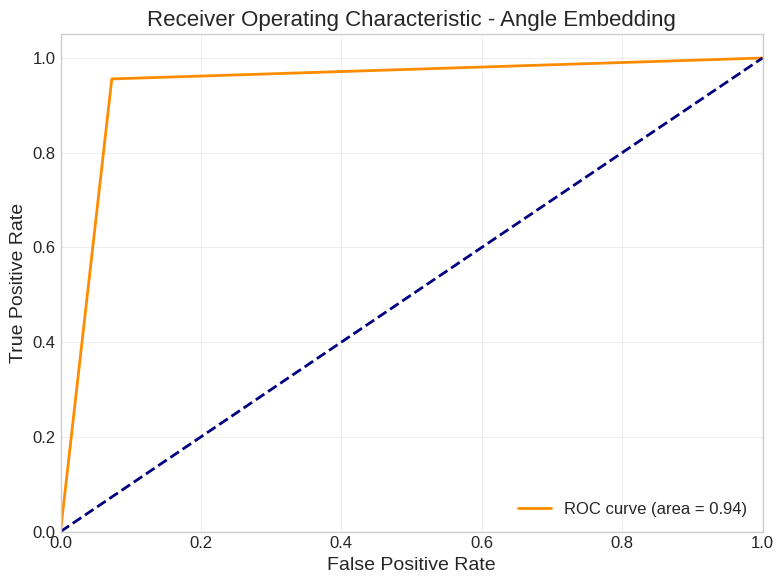


Computing kernel matrices with ZZ Feature Map...
Computing quantum states for ZZ Feature Map training data...


  0%|          | 0/11934 [00:00<?, ?it/s]

Computing quantum states for ZZ Feature Map test data...


  0%|          | 0/3978 [00:00<?, ?it/s]

Computing kernel matrices...

===== Training QSVM with ZZ Feature Map =====
Accuracy: 0.8477
Balanced Accuracy: 0.8459
F1 Score: 0.8471
Classification Report:
              precision    recall  f1-score   support

         Low       0.88      0.80      0.83      1917
        High       0.83      0.90      0.86      2061

    accuracy                           0.85      3978
   macro avg       0.85      0.85      0.85      3978
weighted avg       0.85      0.85      0.85      3978



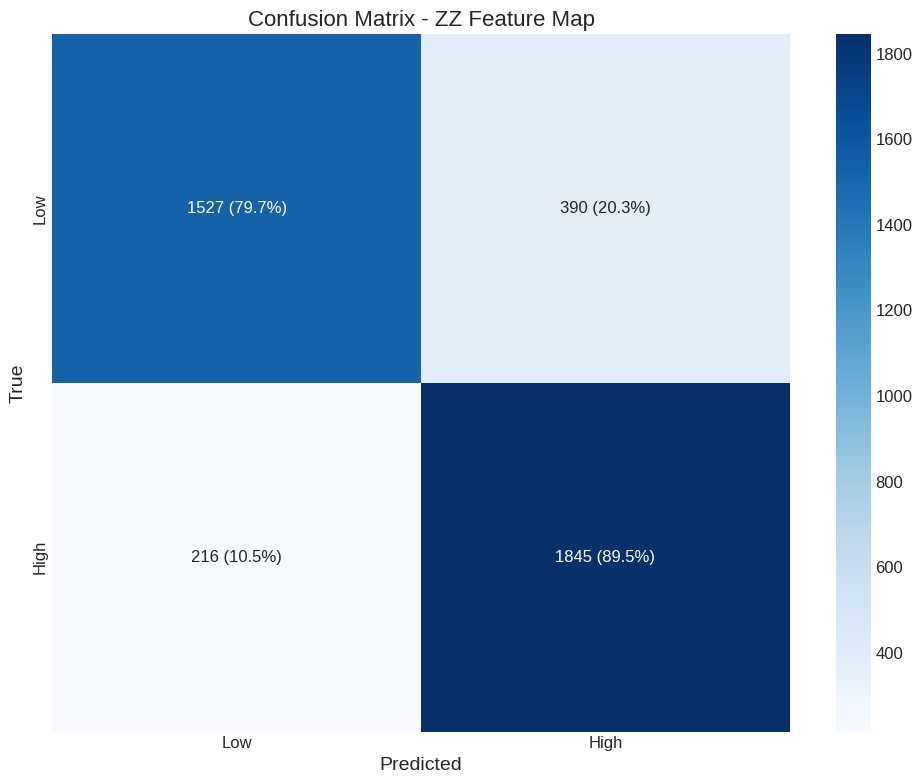

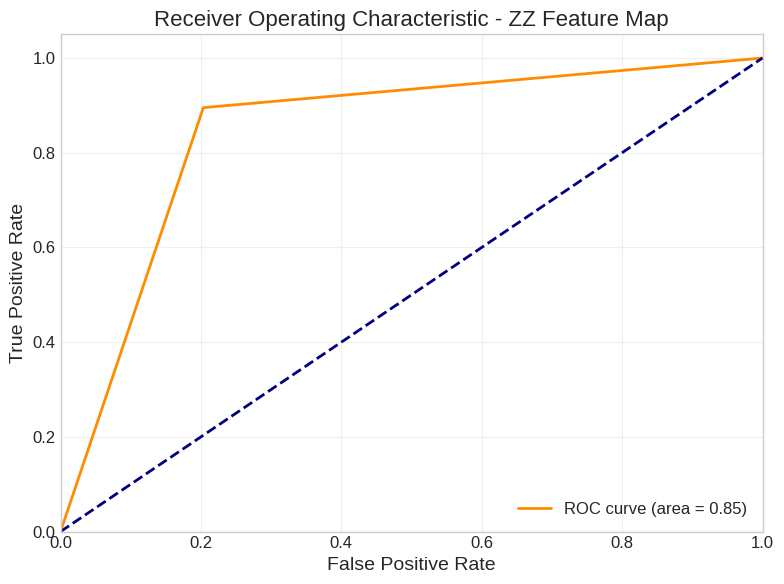

In [ ]:
# Function to train and evaluate QSVM with a given kernel with enhanced visualizations
def train_evaluate_qsvm(K_train, K_test, y_train, y_test, feature_map_name):
    """
    Train and evaluate QSVM with a given precomputed kernel with enhanced metrics.

    Args:
        K_train: Training kernel matrix
        K_test: Test kernel matrix
        y_train: Training labels
        y_test: Test labels
        feature_map_name: Name of the feature map for reporting
    """
    print(f"\n===== Training QSVM with {feature_map_name} =====")

    # Train SVM with precomputed kernel
    qsvm = SVC(kernel="precomputed", class_weight='balanced')
    qsvm.fit(K_train, y_train)

    # Predict and evaluate
    y_pred = qsvm.predict(K_test)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Low", "High"]))

    # Create enhanced confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))

    # Calculate percentages for annotation
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            annot[i, j] = f"{cm[i, j]} ({cm_perc[i, j]:.1f}%)"

    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                xticklabels=["Low", "High"],
                yticklabels=["Low", "High"])
    plt.title(f'Confusion Matrix - {feature_map_name}', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Add ROC curve analysis
    # For binary -1/1 labels, we need to convert to 0/1 for ROC calculation
    y_test_binary = (y_test + 1) / 2
    y_pred_binary = (y_pred + 1) / 2

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_test_binary, y_pred_binary)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {feature_map_name}')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return qsvm, accuracy, balanced_acc, f1, y_pred

# Add this import at the top of your code
from sklearn.inspection import permutation_importance

# Train classical SVM for comparison with enhanced reporting
def train_classical_svm(X_train, X_test, y_train, y_test):
    """
    Train and evaluate a classical SVM model with enhanced reporting.

    Args:
        X_train: Training features
        X_test: Test features
        y_train: Training labels
        y_test: Test labels
    """
    print("\n===== Training Classical SVM for comparison =====")

    # Parameter tuning
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1, 1]
    }

    # Use StratifiedKFold for parameter tuning
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Create and tune the model
    classical_svm = GridSearchCV(
        SVC(kernel='rbf', class_weight='balanced', probability=True),
        param_grid=param_grid,
        cv=cv,
        scoring='balanced_accuracy',
        n_jobs=-1
    )

    classical_svm.fit(X_train, y_train)

    # Print best parameters
    print(f"Best parameters: {classical_svm.best_params_}")
    print(f"Best cross-validation score: {classical_svm.best_score_:.4f}")

    # Get the best model
    best_model = classical_svm.best_estimator_

    # Predict and evaluate
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Low", "High"]))

    # Create enhanced confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))

    # Calculate percentages for annotation
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            annot[i, j] = f"{cm[i, j]} ({cm_perc[i, j]:.1f}%)"

    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                xticklabels=["Low", "High"],
                yticklabels=["Low", "High"])
    plt.title('Confusion Matrix - Classical SVM', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.tight_layout()
    plt.show()

    # ROC curve and AUC
    y_score = best_model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_score)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Classical SVM')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Feature importance through permutation importance
    result = permutation_importance(best_model, X_test, y_test, n_repeats=10,
                                  random_state=42, n_jobs=-1)

    # Create generic feature names since X_test is a numpy array without column names
    feature_names = [f"Feature {i}" for i in range(X_test.shape[1])]

    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values('Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15),
               palette='viridis')
    plt.title('Feature Importance - Classical SVM', fontsize=16)
    plt.xlabel('Permutation Importance', fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return best_model, accuracy, balanced_acc, f1, y_pred, y_score
# Run the models
# Train classical SVM
classical_model, classical_acc, classical_bal_acc, classical_f1, y_pred_classical, y_score_classical = train_classical_svm(
    X_train_normalized, X_test_normalized, y_train, y_test)

# Compute and evaluate with Angle Embedding
print("\nComputing kernel matrices with Angle Embedding...")
K_train_angle, K_test_angle = compute_kernel_matrices(angle_state_circuit, X_train_torch, X_test_torch, "Angle Embedding")
angle_model, angle_acc, angle_bal_acc, angle_f1, y_pred_angle = train_evaluate_qsvm(
    K_train_angle, K_test_angle, y_train, y_test, "Angle Embedding")

# Compute and evaluate with ZZ Feature Map
print("\nComputing kernel matrices with ZZ Feature Map...")
K_train_zz, K_test_zz = compute_kernel_matrices(zz_state_circuit, X_train_torch, X_test_torch, "ZZ Feature Map")
zz_model, zz_acc, zz_bal_acc, zz_f1, y_pred_zz = train_evaluate_qsvm(
    K_train_zz, K_test_zz, y_train, y_test, "ZZ Feature Map")

# 7. Enhanced Results Comparison and Visualization

In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 17.6 MB/s eta 0:00:00


Performing comprehensive model comparison and visualization...

Model Performance Comparison:
                 Model  Accuracy  Balanced Accuracy  F1 Score
         Classical SVM  0.944444           0.943852  0.944404
 QSVM (ZZ Feature Map)  0.847662           0.845877  0.847126
QSVM (Angle Embedding)  0.941931           0.941408  0.941896


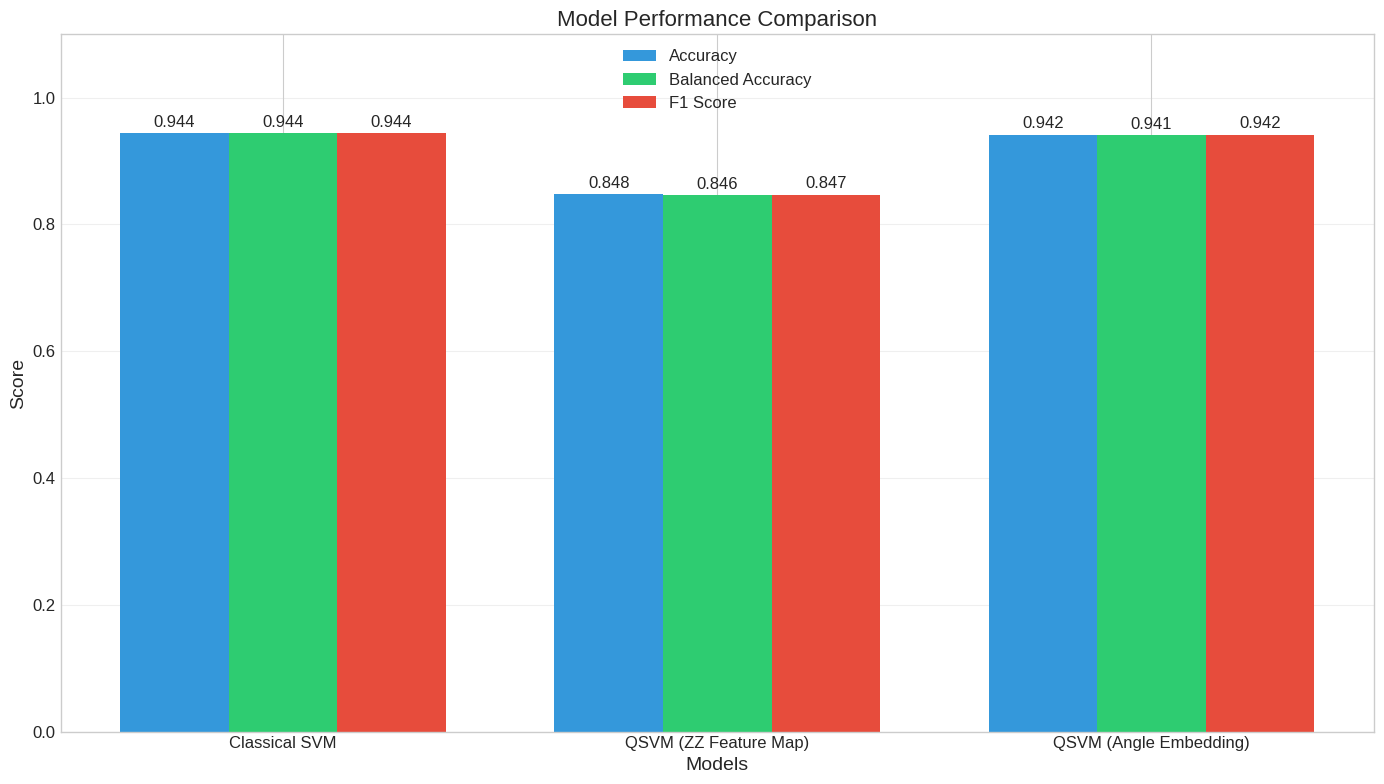

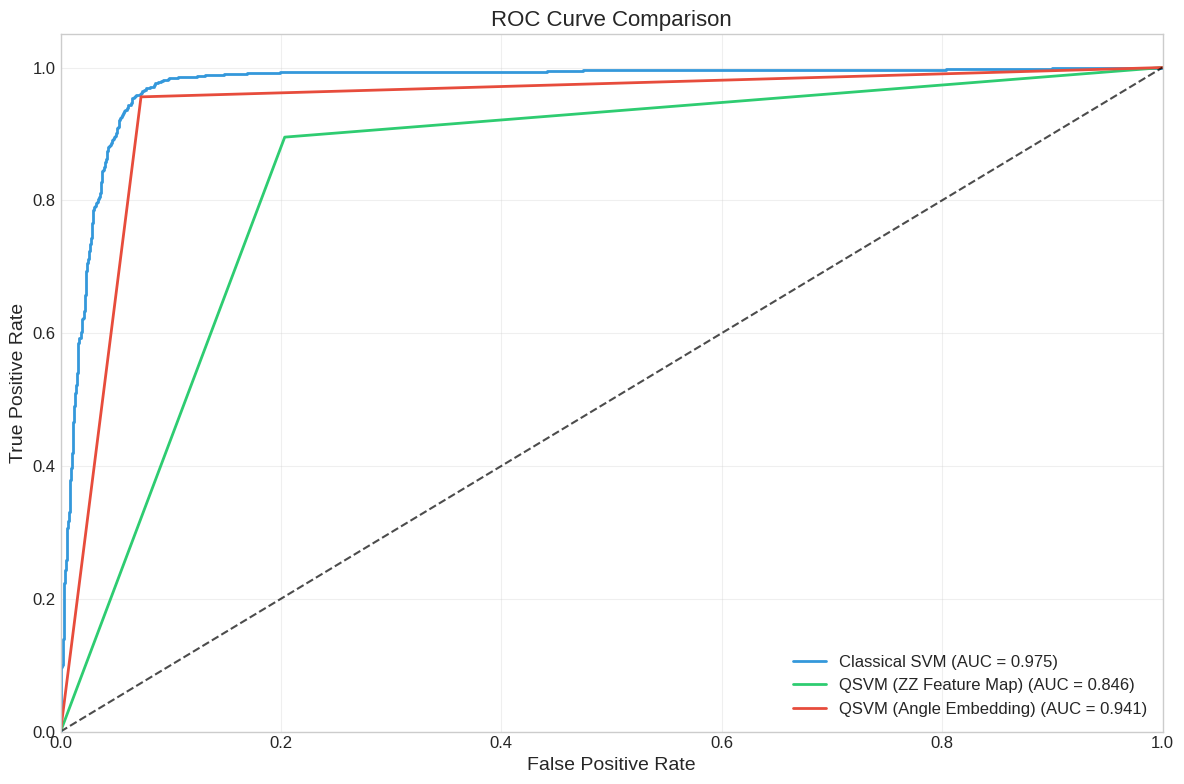

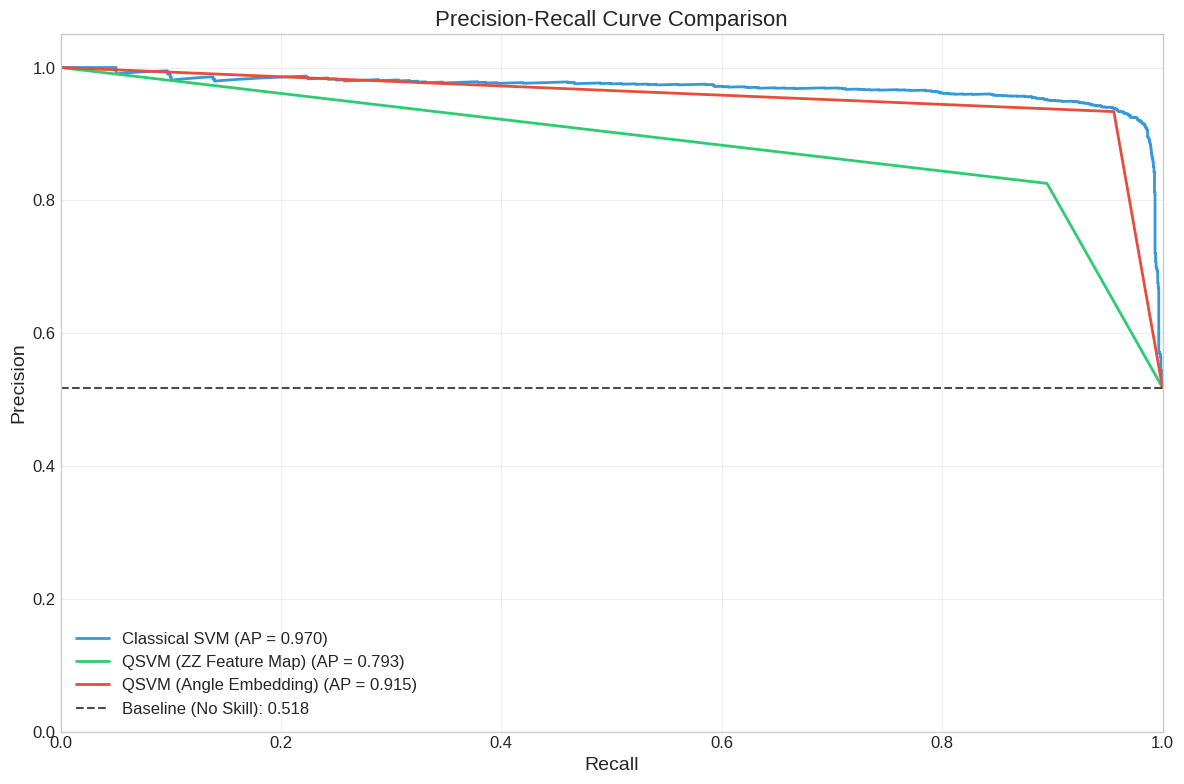

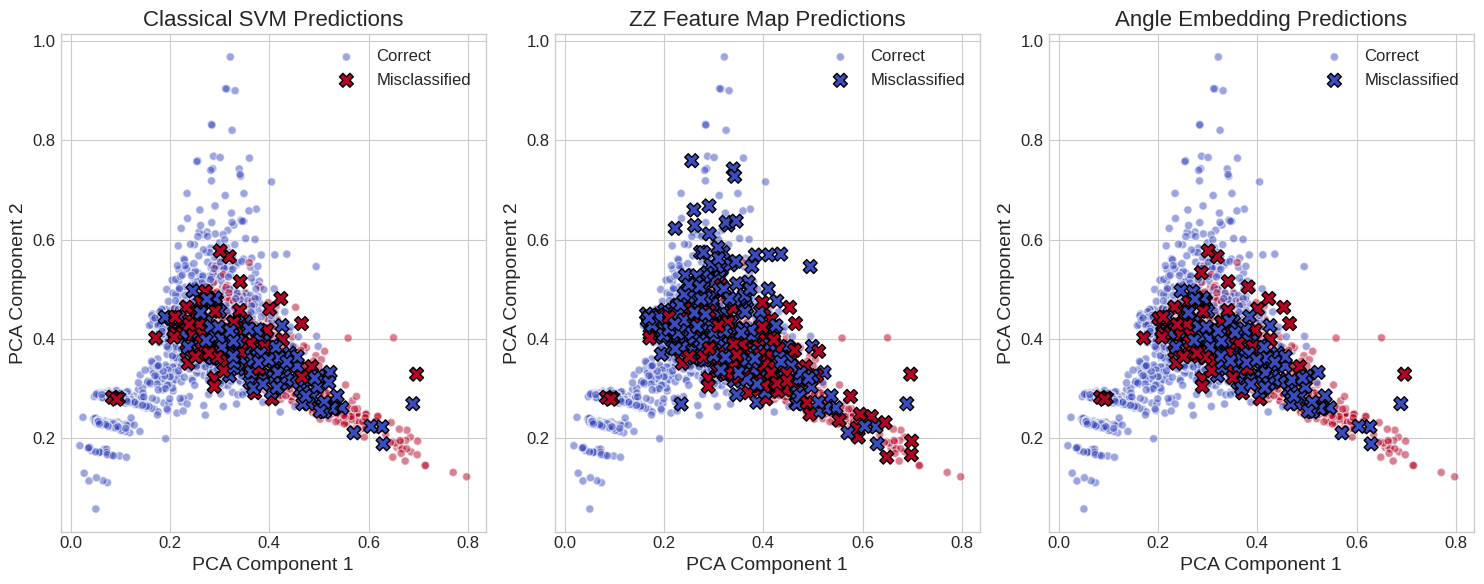


Model Agreement Analysis:
Classical SVM vs ZZ Feature Map: 0.8680 (86.8% agreement)
Classical SVM vs Angle Embedding: 0.9925 (99.2% agreement)
ZZ Feature Map vs Angle Embedding: 0.8670 (86.7% agreement)

McNemar's Test: Classical SVM vs ZZ Feature Map
Chi-squared: 280.8686
p-value: 0.0000
Statistically different performance (α=0.05)

McNemar's Test: Classical SVM vs Angle Embedding
Chi-squared: 2.7000
p-value: 0.1003
Statistically similar performance (α=0.05)

McNemar's Test: ZZ Feature Map vs Angle Embedding
Chi-squared: 264.4159
p-value: 0.0000
Statistically different performance (α=0.05)


In [ ]:
def compare_models(classical_metrics, angle_metrics, zz_metrics):
    """
    Create comprehensive model comparison visualizations.

    Args:
        classical_metrics: Tuple of metrics for classical SVM
        angle_metrics: Tuple of metrics for angle embedding QSVM
        zz_metrics: Tuple of metrics for ZZ feature map QSVM
    """
    # Unpack metrics
    classical_acc, classical_bal_acc, classical_f1, y_pred_classical, y_score_classical = classical_metrics
    angle_acc, angle_bal_acc, angle_f1, y_pred_angle = angle_metrics
    zz_acc, zz_bal_acc, zz_f1, y_pred_zz = zz_metrics

    # Create comparison dataframe
    models = ['Classical SVM', 'QSVM (ZZ Feature Map)', 'QSVM (Angle Embedding)']
    accuracies = [classical_acc, zz_acc, angle_acc]
    balanced_accs = [classical_bal_acc, zz_bal_acc, angle_bal_acc]
    f1_scores = [classical_f1, zz_f1, angle_f1]

    results_df = pd.DataFrame({
        'Model': models,
        'Accuracy': accuracies,
        'Balanced Accuracy': balanced_accs,
        'F1 Score': f1_scores
    })

    print("\nModel Performance Comparison:")
    print(results_df.to_string(index=False))

    # Enhanced bar chart comparison
    plt.figure(figsize=(14, 8))
    x = np.arange(len(models))
    width = 0.25

    plt.bar(x - width, accuracies, width, label='Accuracy', color='#3498db')
    plt.bar(x, balanced_accs, width, label='Balanced Accuracy', color='#2ecc71')
    plt.bar(x + width, f1_scores, width, label='F1 Score', color='#e74c3c')

    plt.xlabel('Models', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.title('Model Performance Comparison', fontsize=16)
    plt.xticks(x, models)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for i in range(len(models)):
        plt.text(i - width, accuracies[i] + 0.01, f'{accuracies[i]:.3f}', ha='center')
        plt.text(i, balanced_accs[i] + 0.01, f'{balanced_accs[i]:.3f}', ha='center')
        plt.text(i + width, f1_scores[i] + 0.01, f'{f1_scores[i]:.3f}', ha='center')

    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

    # Combined ROC curve comparison
    plt.figure(figsize=(12, 8))

    # Classical SVM
    fpr_classical, tpr_classical, _ = roc_curve(y_test, y_score_classical)
    plt.plot(fpr_classical, tpr_classical,
             label=f'Classical SVM (AUC = {roc_auc_score(y_test, y_score_classical):.3f})',
             lw=2, color='#3498db')

    # For ZZ Feature Map
    fpr_zz, tpr_zz, _ = roc_curve((y_test + 1) / 2, (y_pred_zz + 1) / 2)  # Convert from -1/1 to 0/1
    plt.plot(fpr_zz, tpr_zz,
             label=f'QSVM (ZZ Feature Map) (AUC = {roc_auc_score((y_test + 1) / 2, (y_pred_zz + 1) / 2):.3f})',
             lw=2, color='#2ecc71')

    # For Angle Embedding
    fpr_angle, tpr_angle, _ = roc_curve((y_test + 1) / 2, (y_pred_angle + 1) / 2)  # Convert from -1/1 to 0/1
    plt.plot(fpr_angle, tpr_angle,
             label=f'QSVM (Angle Embedding) (AUC = {roc_auc_score((y_test + 1) / 2, (y_pred_angle + 1) / 2):.3f})',
             lw=2, color='#e74c3c')

    plt.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve Comparison', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Precision-Recall curve comparison
    plt.figure(figsize=(12, 8))

    # Classical SVM
    precision_classical, recall_classical, _ = precision_recall_curve(y_test, y_score_classical)
    avg_precision_classical = average_precision_score(y_test, y_score_classical)
    plt.plot(recall_classical, precision_classical,
             label=f'Classical SVM (AP = {avg_precision_classical:.3f})',
             lw=2, color='#3498db')

    # For ZZ Feature Map - convert to probabilities for PR curve
    y_test_binary = (y_test + 1) / 2
    y_pred_zz_binary = (y_pred_zz + 1) / 2
    precision_zz, recall_zz, _ = precision_recall_curve(y_test_binary, y_pred_zz_binary)
    avg_precision_zz = average_precision_score(y_test_binary, y_pred_zz_binary)
    plt.plot(recall_zz, precision_zz,
             label=f'QSVM (ZZ Feature Map) (AP = {avg_precision_zz:.3f})',
             lw=2, color='#2ecc71')

    # For Angle Embedding
    y_pred_angle_binary = (y_pred_angle + 1) / 2
    precision_angle, recall_angle, _ = precision_recall_curve(y_test_binary, y_pred_angle_binary)
    avg_precision_angle = average_precision_score(y_test_binary, y_pred_angle_binary)
    plt.plot(recall_angle, precision_angle,
             label=f'QSVM (Angle Embedding) (AP = {avg_precision_angle:.3f})',
             lw=2, color='#e74c3c')

    # Add baseline
    no_skill = len(y_test_binary[y_test_binary==1]) / len(y_test_binary)
    plt.plot([0, 1], [no_skill, no_skill], 'k--', lw=1.5, alpha=0.7, label=f'Baseline (No Skill): {no_skill:.3f}')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Precision-Recall Curve Comparison', fontsize=16)
    plt.legend(loc='lower left', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Create a detailed error analysis
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 1)

    # For classical SVM
    classical_correct = y_test == y_pred_classical
    classical_errors = ~classical_correct

    plt.scatter(X_test_normalized[classical_correct, 0], X_test_normalized[classical_correct, 1],
               c=y_test[classical_correct], cmap='coolwarm', marker='o', alpha=0.5, edgecolors='white',
               label='Correct')
    plt.scatter(X_test_normalized[classical_errors, 0], X_test_normalized[classical_errors, 1],
               c=y_test[classical_errors], cmap='coolwarm', marker='X', s=100, alpha=1.0, edgecolors='black',
               label='Misclassified')
    plt.title('Classical SVM Predictions')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    # For ZZ Feature Map
    plt.subplot(1, 3, 2)
    zz_correct = y_test == y_pred_zz
    zz_errors = ~zz_correct

    plt.scatter(X_test_normalized[zz_correct, 0], X_test_normalized[zz_correct, 1],
               c=y_test[zz_correct], cmap='coolwarm', marker='o', alpha=0.5, edgecolors='white',
               label='Correct')
    plt.scatter(X_test_normalized[zz_errors, 0], X_test_normalized[zz_errors, 1],
               c=y_test[zz_errors], cmap='coolwarm', marker='X', s=100, alpha=1.0, edgecolors='black',
               label='Misclassified')
    plt.title('ZZ Feature Map Predictions')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    # For Angle Embedding
    plt.subplot(1, 3, 3)
    angle_correct = y_test == y_pred_angle
    angle_errors = ~angle_correct

    plt.scatter(X_test_normalized[angle_correct, 0], X_test_normalized[angle_correct, 1],
               c=y_test[angle_correct], cmap='coolwarm', marker='o', alpha=0.5, edgecolors='white',
               label='Correct')
    plt.scatter(X_test_normalized[angle_errors, 0], X_test_normalized[angle_errors, 1],
               c=y_test[angle_errors], cmap='coolwarm', marker='X', s=100, alpha=1.0, edgecolors='black',
               label='Misclassified')
    plt.title('Angle Embedding Predictions')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Summary table of agreement between models
    classical_vs_zz = np.mean(y_pred_classical == y_pred_zz)
    classical_vs_angle = np.mean(y_pred_classical == y_pred_angle)
    zz_vs_angle = np.mean(y_pred_zz == y_pred_angle)

    print("\nModel Agreement Analysis:")
    print(f"Classical SVM vs ZZ Feature Map: {classical_vs_zz:.4f} ({classical_vs_zz*100:.1f}% agreement)")
    print(f"Classical SVM vs Angle Embedding: {classical_vs_angle:.4f} ({classical_vs_angle*100:.1f}% agreement)")
    print(f"ZZ Feature Map vs Angle Embedding: {zz_vs_angle:.4f} ({zz_vs_angle*100:.1f}% agreement)")

    # Advanced analysis: McNemar's test for model comparison
    from statsmodels.stats.contingency_tables import mcnemar

    def perform_mcnemars_test(y_true, pred_a, pred_b, model_a_name, model_b_name):
        # Create contingency table
        # [both correct, a correct/b wrong]
        # [a wrong/b correct, both wrong]
        table = [
            [(pred_a == y_true) & (pred_b == y_true), (pred_a == y_true) & (pred_b != y_true)],
            [(pred_a != y_true) & (pred_b == y_true), (pred_a != y_true) & (pred_b != y_true)]
        ]
        table = np.array([[np.sum(cell) for cell in row] for row in table])

        # Perform McNemar's test
        result = mcnemar(table, exact=False, correction=True)

        print(f"\nMcNemar's Test: {model_a_name} vs {model_b_name}")
        print(f"Chi-squared: {result.statistic:.4f}")
        print(f"p-value: {result.pvalue:.4f}")
        print(f"Statistically {'different' if result.pvalue < 0.05 else 'similar'} performance (α=0.05)")

        return result

    # Perform McNemar's test for all model pairs
    classical_vs_zz_test = perform_mcnemars_test(y_test, y_pred_classical, y_pred_zz,
                                                "Classical SVM", "ZZ Feature Map")
    classical_vs_angle_test = perform_mcnemars_test(y_test, y_pred_classical, y_pred_angle,
                                                  "Classical SVM", "Angle Embedding")
    zz_vs_angle_test = perform_mcnemars_test(y_test, y_pred_zz, y_pred_angle,
                                            "ZZ Feature Map", "Angle Embedding")

    # Return the aggregated metrics for further analysis if needed
    return {
        'classical': [classical_acc, classical_bal_acc, classical_f1],
        'zz_feature_map': [zz_acc, zz_bal_acc, zz_f1],
        'angle_embedding': [angle_acc, angle_bal_acc, angle_f1],
        'model_agreement': {
            'classical_vs_zz': classical_vs_zz,
            'classical_vs_angle': classical_vs_angle,
            'zz_vs_angle': zz_vs_angle
        },
        'mcnemars_tests': {
            'classical_vs_zz': classical_vs_zz_test,
            'classical_vs_angle': classical_vs_angle_test,
            'zz_vs_angle': zz_vs_angle_test
        }
    }

# Execute the comprehensive model comparison
print("Performing comprehensive model comparison and visualization...")
comparison_results = compare_models(
    (classical_acc, classical_bal_acc, classical_f1, y_pred_classical, y_score_classical),
    (angle_acc, angle_bal_acc, angle_f1, y_pred_angle),
    (zz_acc, zz_bal_acc, zz_f1, y_pred_zz)
)

# 8. Quantum Circuit Visualization and Analysis


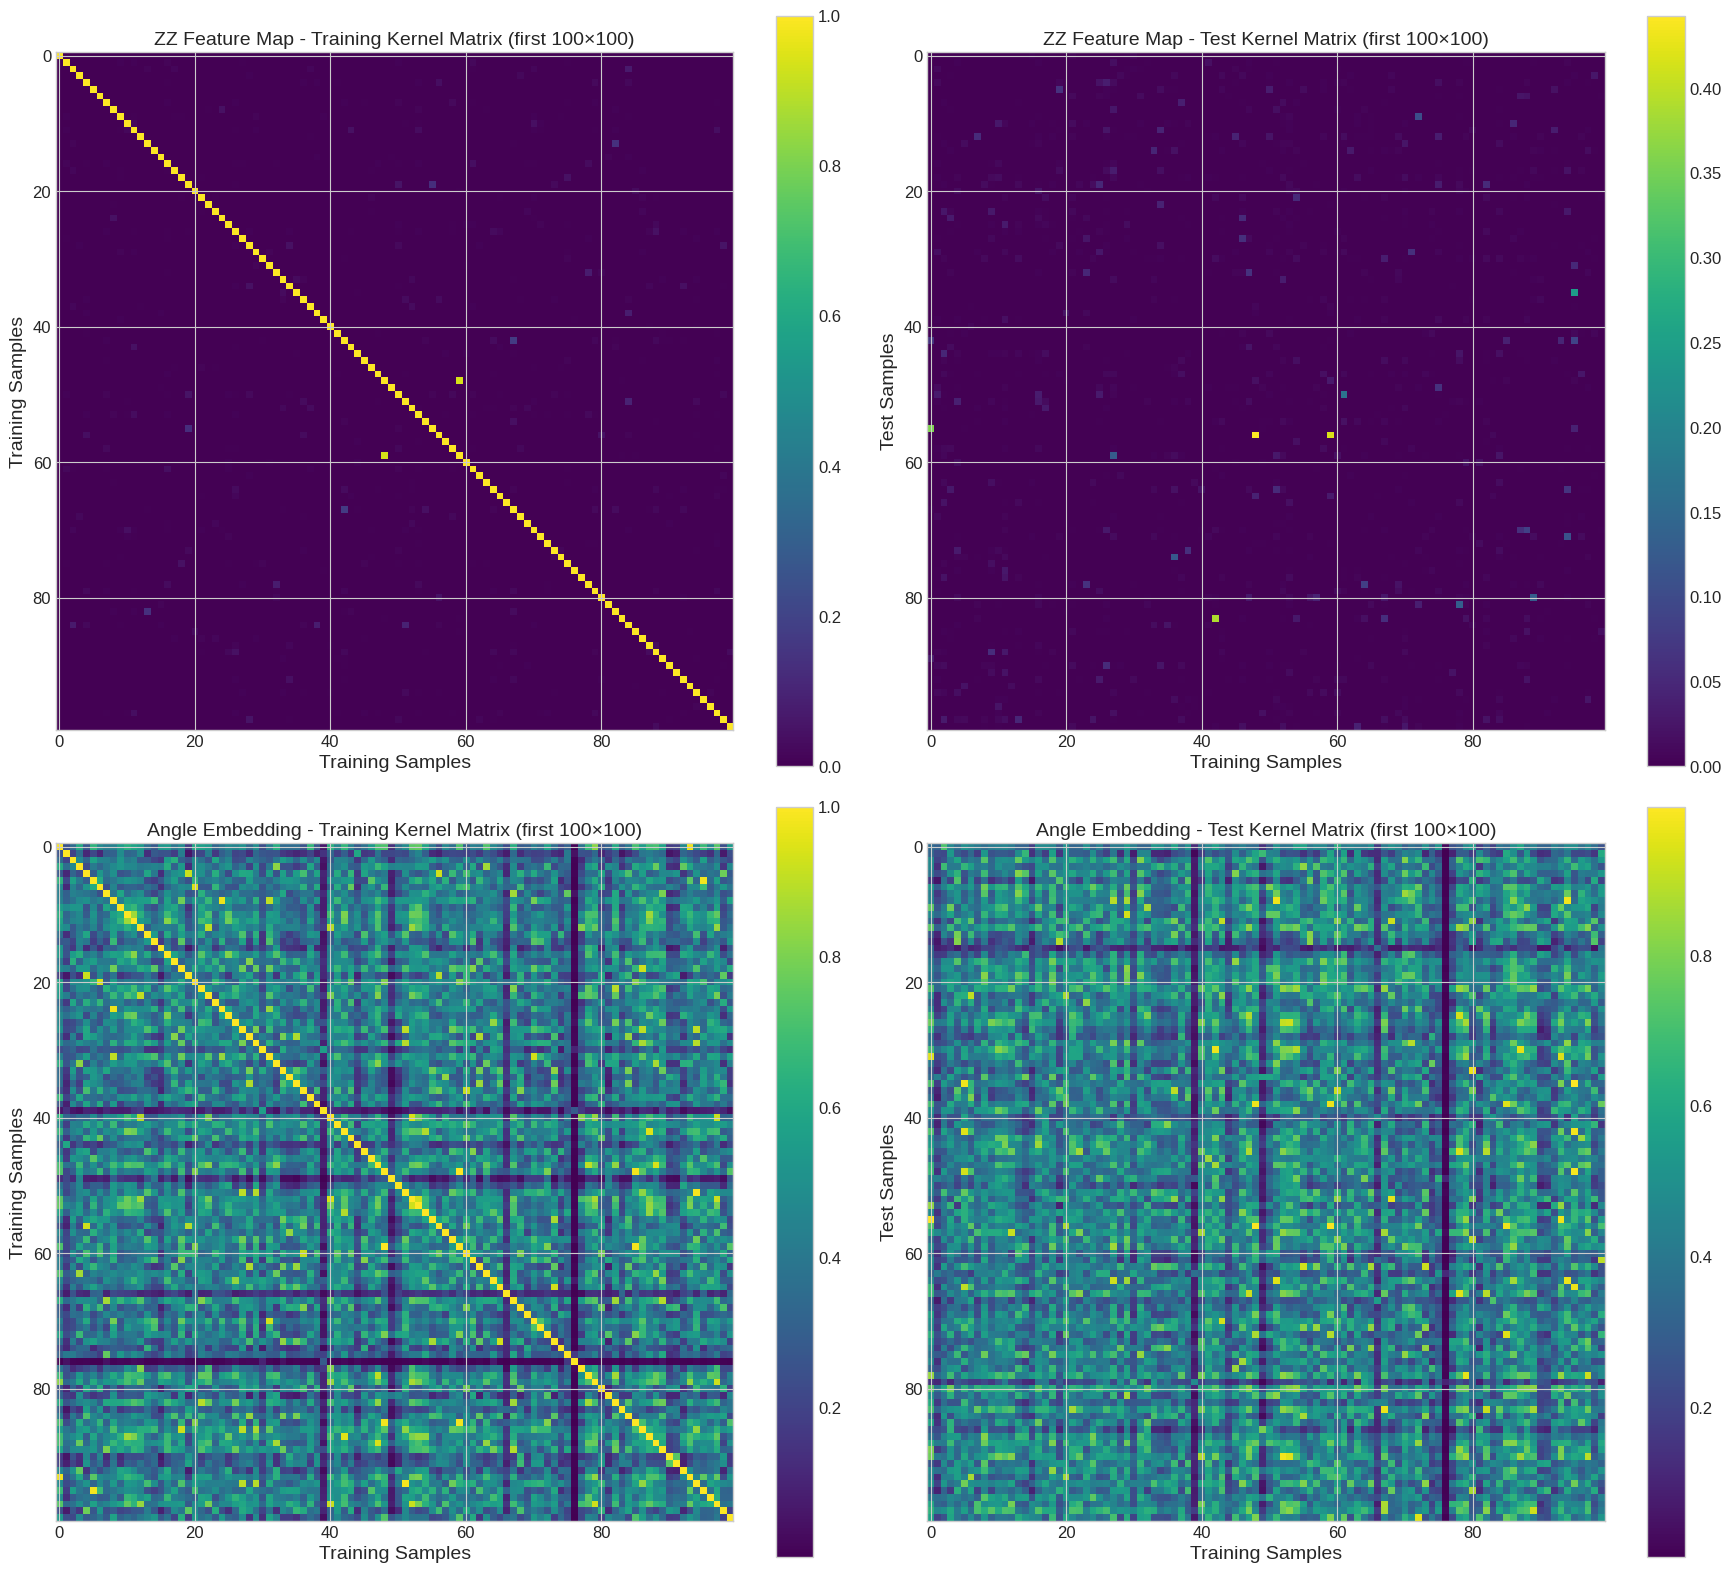


Kernel Matrix Statistics:

ZZ Feature Map:
  - Training kernel min/max: 0.0000/1.0000
  - Training kernel mean/std: 0.0014/0.0121
  - Test kernel min/max: 0.0000/1.0000
  - Test kernel mean/std: 0.0013/0.0081

Angle Embedding:
  - Training kernel min/max: 0.0000/1.0000
  - Training kernel mean/std: 0.4333/0.1680
  - Test kernel min/max: 0.0000/1.0000
  - Test kernel mean/std: 0.4346/0.1681

Kernel Structure Analysis:
ZZ Feature Map diagonal dominance: 734.1145
Angle Embedding diagonal dominance: 2.3078


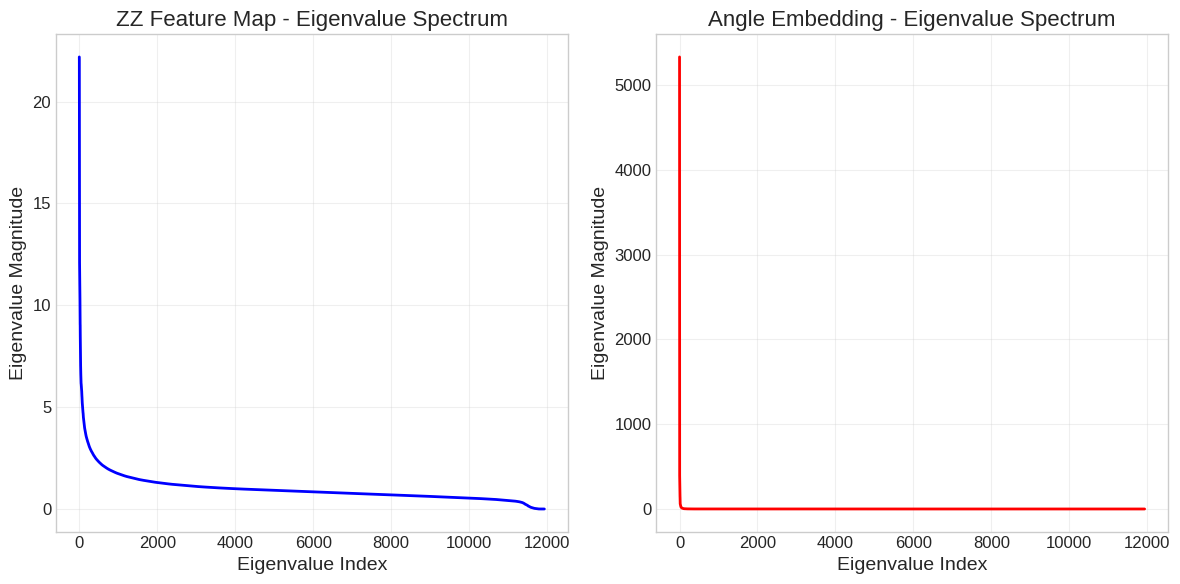


ZZ Feature Map effective rank: 11931 (out of 11934)
Angle Embedding effective rank: 11314 (out of 11934)


In [ ]:
def visualize_kernel_matrices(K_train_zz, K_test_zz, K_train_angle, K_test_angle):
    """
    Visualize the quantum kernel matrices to compare their structures.

    Args:
        K_train_zz: Training kernel matrix from ZZ feature map
        K_test_zz: Test kernel matrix from ZZ feature map
        K_train_angle: Training kernel matrix from Angle embedding
        K_test_angle: Test kernel matrix from Angle embedding
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))

    # Sample size for visualization (use full matrix if small, otherwise sample)
    sample_size = min(100, K_train_zz.shape[0])

    # Visualize ZZ Feature Map kernel matrices
    im0 = axes[0, 0].imshow(K_train_zz[:sample_size, :sample_size], cmap='viridis')
    axes[0, 0].set_title(f'ZZ Feature Map - Training Kernel Matrix (first {sample_size}×{sample_size})', fontsize=14)
    axes[0, 0].set_xlabel('Training Samples')
    axes[0, 0].set_ylabel('Training Samples')
    fig.colorbar(im0, ax=axes[0, 0])

    im1 = axes[0, 1].imshow(K_test_zz[:sample_size, :sample_size], cmap='viridis')
    axes[0, 1].set_title(f'ZZ Feature Map - Test Kernel Matrix (first {sample_size}×{sample_size})', fontsize=14)
    axes[0, 1].set_xlabel('Training Samples')
    axes[0, 1].set_ylabel('Test Samples')
    fig.colorbar(im1, ax=axes[0, 1])

    # Visualize Angle Embedding kernel matrices
    im2 = axes[1, 0].imshow(K_train_angle[:sample_size, :sample_size], cmap='viridis')
    axes[1, 0].set_title(f'Angle Embedding - Training Kernel Matrix (first {sample_size}×{sample_size})', fontsize=14)
    axes[1, 0].set_xlabel('Training Samples')
    axes[1, 0].set_ylabel('Training Samples')
    fig.colorbar(im2, ax=axes[1, 0])

    im3 = axes[1, 1].imshow(K_test_angle[:sample_size, :sample_size], cmap='viridis')
    axes[1, 1].set_title(f'Angle Embedding - Test Kernel Matrix (first {sample_size}×{sample_size})', fontsize=14)
    axes[1, 1].set_xlabel('Training Samples')
    axes[1, 1].set_ylabel('Test Samples')
    fig.colorbar(im3, ax=axes[1, 1])

    plt.tight_layout()
    plt.show()

    # Additional analysis: kernel statistics
    print("\nKernel Matrix Statistics:")
    print("\nZZ Feature Map:")
    print(f"  - Training kernel min/max: {np.min(K_train_zz):.4f}/{np.max(K_train_zz):.4f}")
    print(f"  - Training kernel mean/std: {np.mean(K_train_zz):.4f}/{np.std(K_train_zz):.4f}")
    print(f"  - Test kernel min/max: {np.min(K_test_zz):.4f}/{np.max(K_test_zz):.4f}")
    print(f"  - Test kernel mean/std: {np.mean(K_test_zz):.4f}/{np.std(K_test_zz):.4f}")

    print("\nAngle Embedding:")
    print(f"  - Training kernel min/max: {np.min(K_train_angle):.4f}/{np.max(K_train_angle):.4f}")
    print(f"  - Training kernel mean/std: {np.mean(K_train_angle):.4f}/{np.std(K_train_angle):.4f}")
    print(f"  - Test kernel min/max: {np.min(K_test_angle):.4f}/{np.max(K_test_angle):.4f}")
    print(f"  - Test kernel mean/std: {np.mean(K_test_angle):.4f}/{np.std(K_test_angle):.4f}")

    # Analyze kernel matrix structure
    zz_diag_dominance = np.mean(np.diag(K_train_zz)) / np.mean(K_train_zz)
    angle_diag_dominance = np.mean(np.diag(K_train_angle)) / np.mean(K_train_angle)

    print("\nKernel Structure Analysis:")
    print(f"ZZ Feature Map diagonal dominance: {zz_diag_dominance:.4f}")
    print(f"Angle Embedding diagonal dominance: {angle_diag_dominance:.4f}")

    # Calculate eigenvalues to check kernel expressivity
    zz_eigenvalues = np.linalg.eigvalsh(K_train_zz)
    angle_eigenvalues = np.linalg.eigvalsh(K_train_angle)

    # Plot eigenvalue distributions
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(zz_eigenvalues[::-1], 'b-', linewidth=2)
    plt.title('ZZ Feature Map - Eigenvalue Spectrum')
    plt.xlabel('Eigenvalue Index')
    plt.ylabel('Eigenvalue Magnitude')
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(angle_eigenvalues[::-1], 'r-', linewidth=2)
    plt.title('Angle Embedding - Eigenvalue Spectrum')
    plt.xlabel('Eigenvalue Index')
    plt.ylabel('Eigenvalue Magnitude')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print expressivity metrics
    zz_effective_rank = np.sum(zz_eigenvalues > 1e-10)
    angle_effective_rank = np.sum(angle_eigenvalues > 1e-10)

    print(f"\nZZ Feature Map effective rank: {zz_effective_rank} (out of {len(zz_eigenvalues)})")
    print(f"Angle Embedding effective rank: {angle_effective_rank} (out of {len(angle_eigenvalues)})")
visualize_kernel_matrices(K_train_zz, K_test_zz, K_train_angle, K_test_angle)

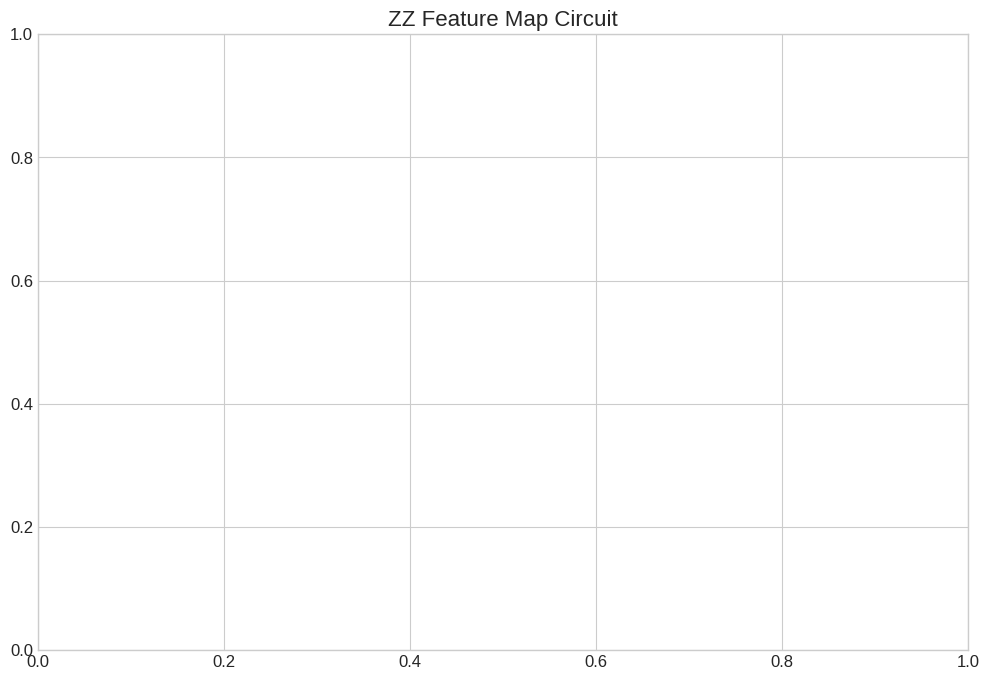

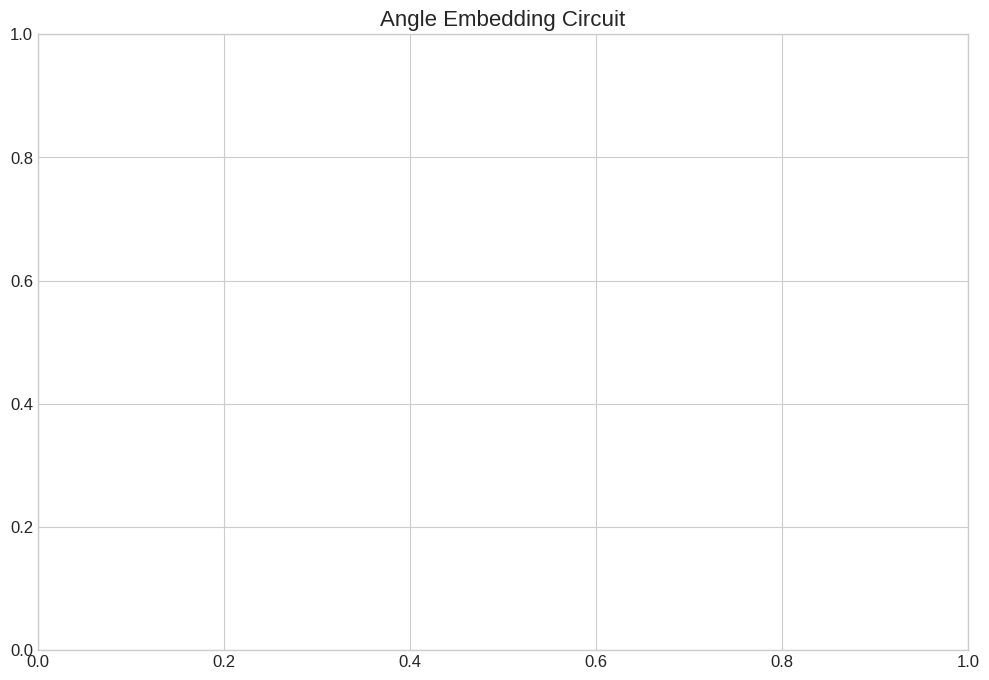

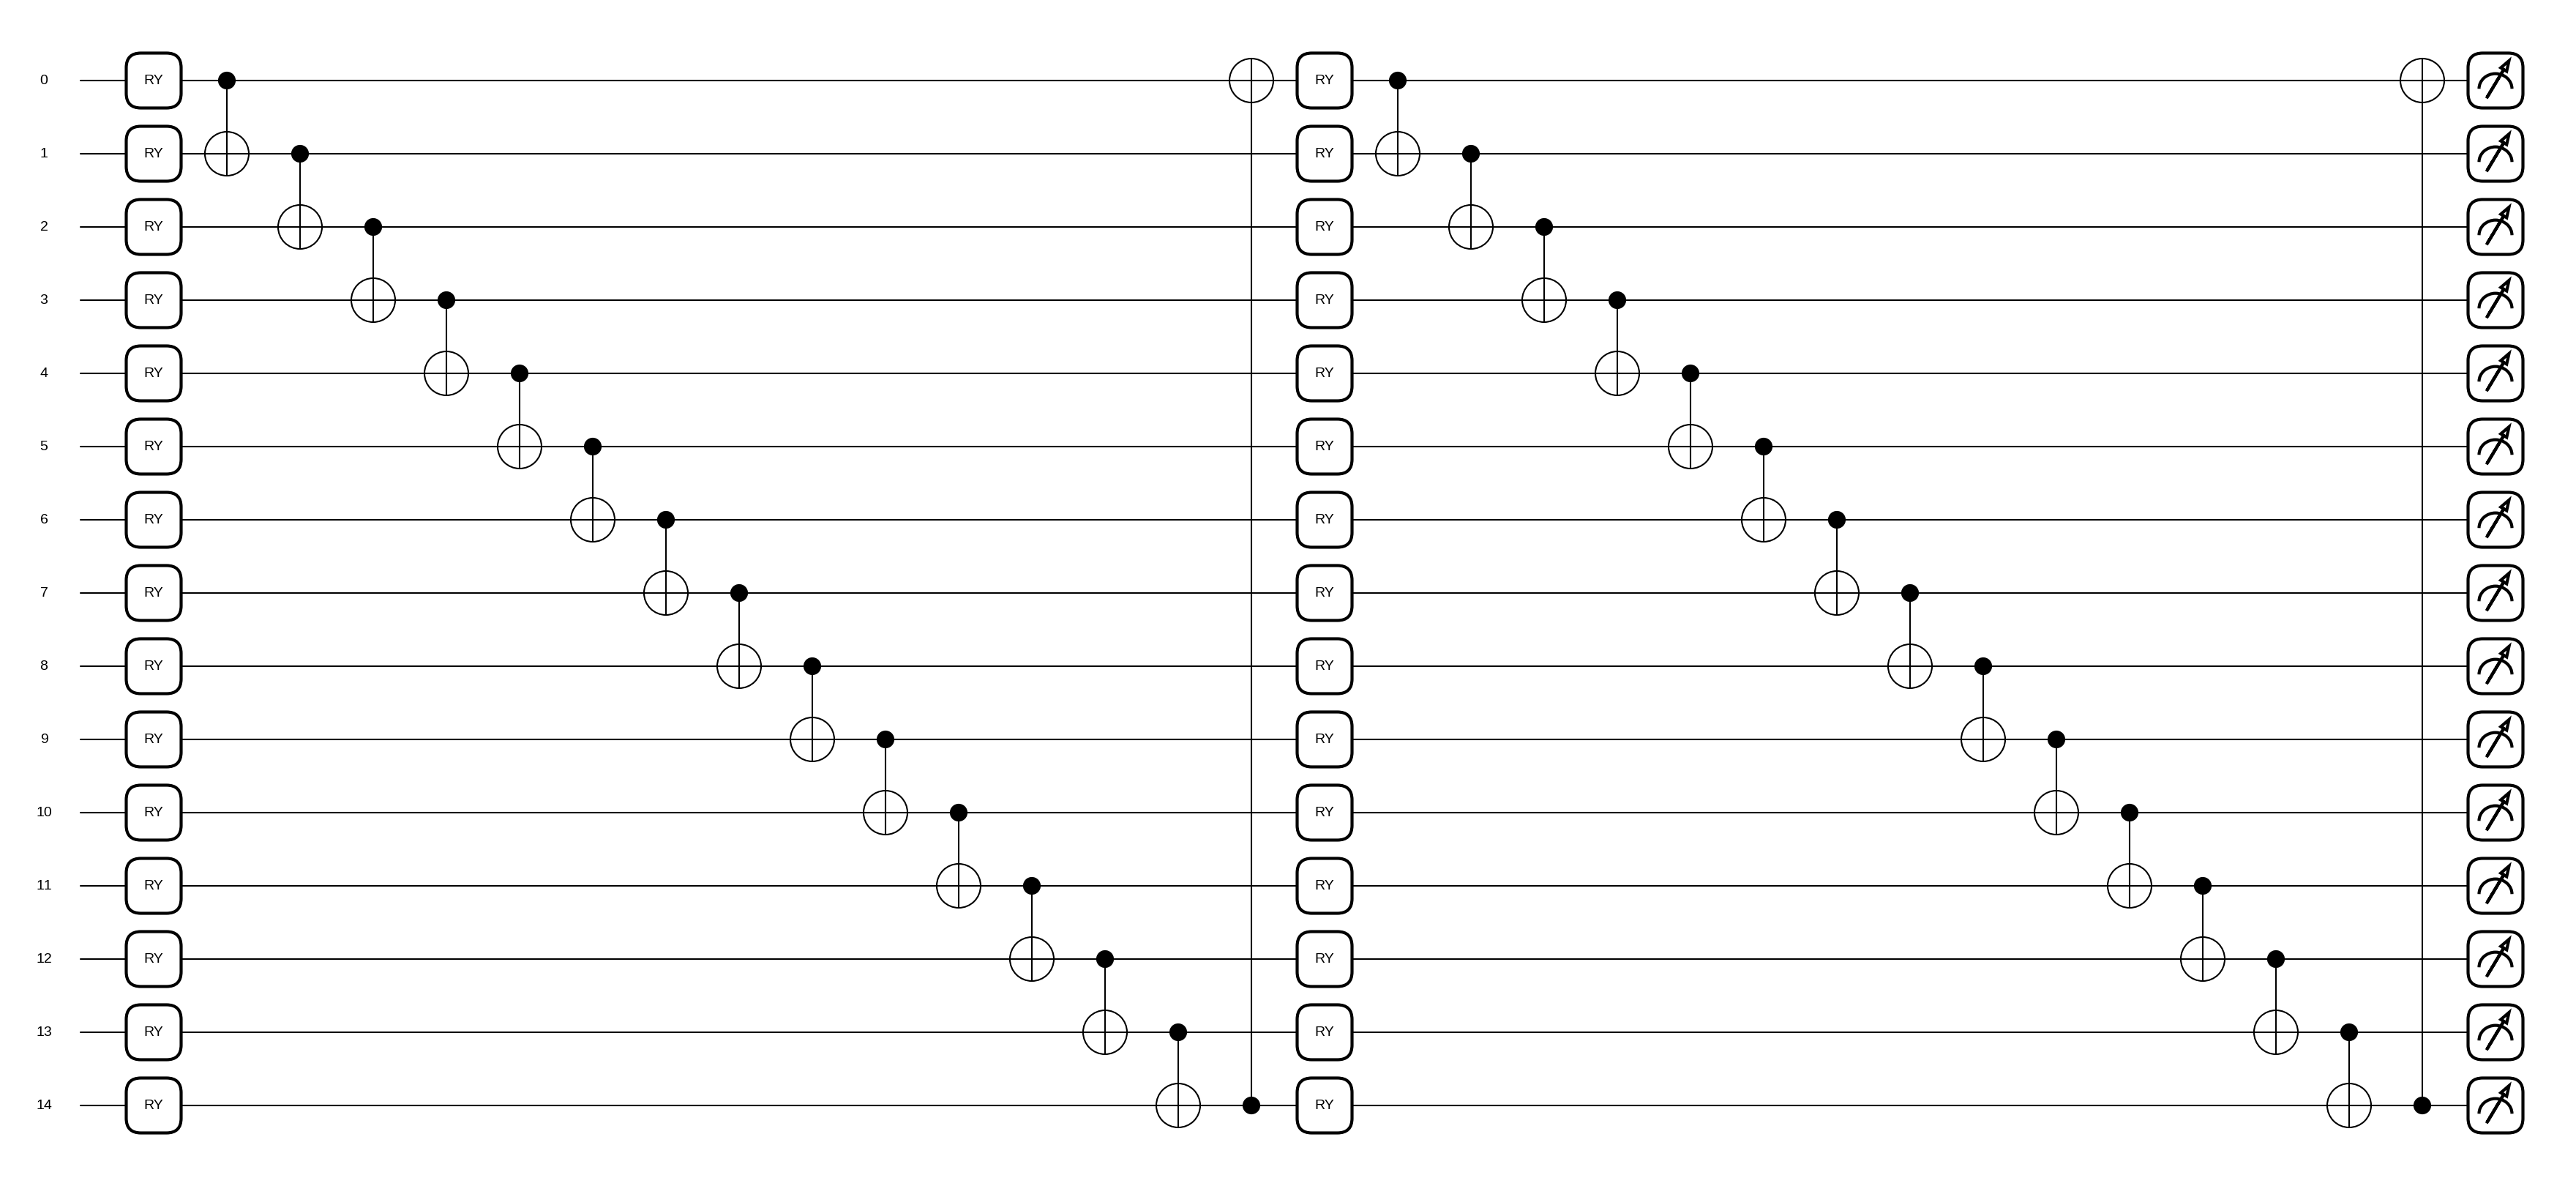


Circuit Complexity Analysis:
ZZ Feature Map:
  - Device wires: 15
  - Tape wires: 15
  - Resources: num_wires: 15
num_gates: 697
depth: 134
shots: Shots(total=None)
gate_types:
{'Hadamard': 30, 'RZ': 240, 'CZ': 420, 'CNOT': 7}
gate_sizes:
{1: 270, 2: 427}
  - Number of observables: 1

Angle Embedding:
  - Device wires: 15
  - Tape wires: 15
  - Resources: num_wires: 15
num_gates: 60
depth: 32
shots: Shots(total=None)
gate_types:
{'RY': 30, 'CNOT': 30}
gate_sizes:
{1: 30, 2: 30}
  - Number of observables: 1


In [ ]:
def visualize_quantum_circuit_depth(n_qubits=15):
    """
    Visualize and analyze the complexity of quantum circuits used in the model.

    Args:
        n_qubits: Number of qubits used in the circuits
    """
    # Setup sample data
    sample_data = np.random.rand(n_qubits)

    # Create figures separately to avoid layout issues
    plt.figure(figsize=(12, 8))
    plt.title("ZZ Feature Map Circuit", fontsize=16)

    # ZZ Feature Map depth analysis
    @qml.qnode(dev)
    def zz_circuit_analysis(x):
        ZZFeatureMap(n_qubits, x, reps=2)
        return qml.state()

    # Draw ZZ circuit
    qml.draw_mpl(zz_circuit_analysis)(sample_data)
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.title("Angle Embedding Circuit", fontsize=16)

    # Angle Embedding depth analysis
    @qml.qnode(dev)
    def angle_circuit_analysis(x):
        AngleEmbeddingCircuit(n_qubits, x, reps=2)
        return qml.state()

    # Draw Angle Embedding circuit
    qml.draw_mpl(angle_circuit_analysis)(sample_data)
    plt.show()

    # Analyze circuit complexity using available keys from specs
    zz_circuit_info = qml.specs(zz_circuit_analysis)(sample_data)
    angle_circuit_info = qml.specs(angle_circuit_analysis)(sample_data)

    print("\nCircuit Complexity Analysis:")
    print(f"ZZ Feature Map:")
    print(f"  - Device wires: {zz_circuit_info['num_device_wires']}")
    print(f"  - Tape wires: {zz_circuit_info['num_tape_wires']}")
    print(f"  - Resources: {zz_circuit_info['resources']}")
    print(f"  - Number of observables: {zz_circuit_info['num_observables']}")

    print(f"\nAngle Embedding:")
    print(f"  - Device wires: {angle_circuit_info['num_device_wires']}")
    print(f"  - Tape wires: {angle_circuit_info['num_tape_wires']}")
    print(f"  - Resources: {angle_circuit_info['resources']}")
    print(f"  - Number of observables: {angle_circuit_info['num_observables']}")

# Visualize quantum circuits
visualize_quantum_circuit_depth()

# 9. Feature Importance and Analysis for Quantum Models


Feature Impact Analysis:
Prediction difference: Classical vs ZZ: 0.1320 (13.2%)
Prediction difference: Classical vs Angle: 0.0075 (0.8%)
Prediction difference: ZZ vs Angle: 0.1330 (13.3%)


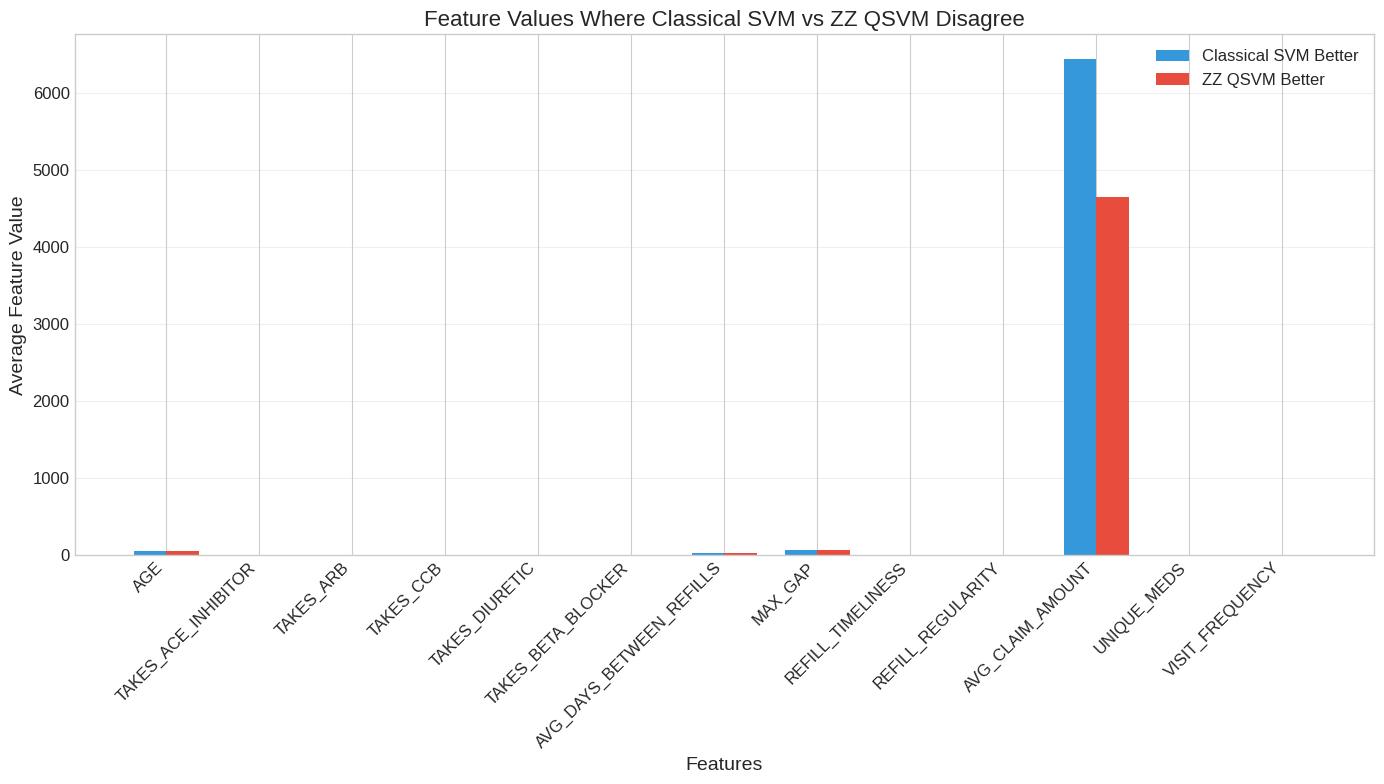


Top Discriminating Features Between Classical SVM and ZZ QSVM:
                                           Feature  Classical SVM Mean  \
TAKES_DIURETIC                      TAKES_DIURETIC            0.270330   
AVG_DAYS_BETWEEN_REFILLS  AVG_DAYS_BETWEEN_REFILLS           32.961628   
AVG_CLAIM_AMOUNT                  AVG_CLAIM_AMOUNT         6435.616843   
TAKES_ACE_INHIBITOR            TAKES_ACE_INHIBITOR            0.052747   
UNIQUE_MEDS                            UNIQUE_MEDS            2.989011   

                          ZZ QSVM Mean  Difference Ratio  
TAKES_DIURETIC                0.414286         -0.210273  
AVG_DAYS_BETWEEN_REFILLS     23.481913          0.167950  
AVG_CLAIM_AMOUNT           4642.061162          0.161907  
TAKES_ACE_INHIBITOR           0.071429         -0.150442  
UNIQUE_MEDS                   3.800000         -0.119456  


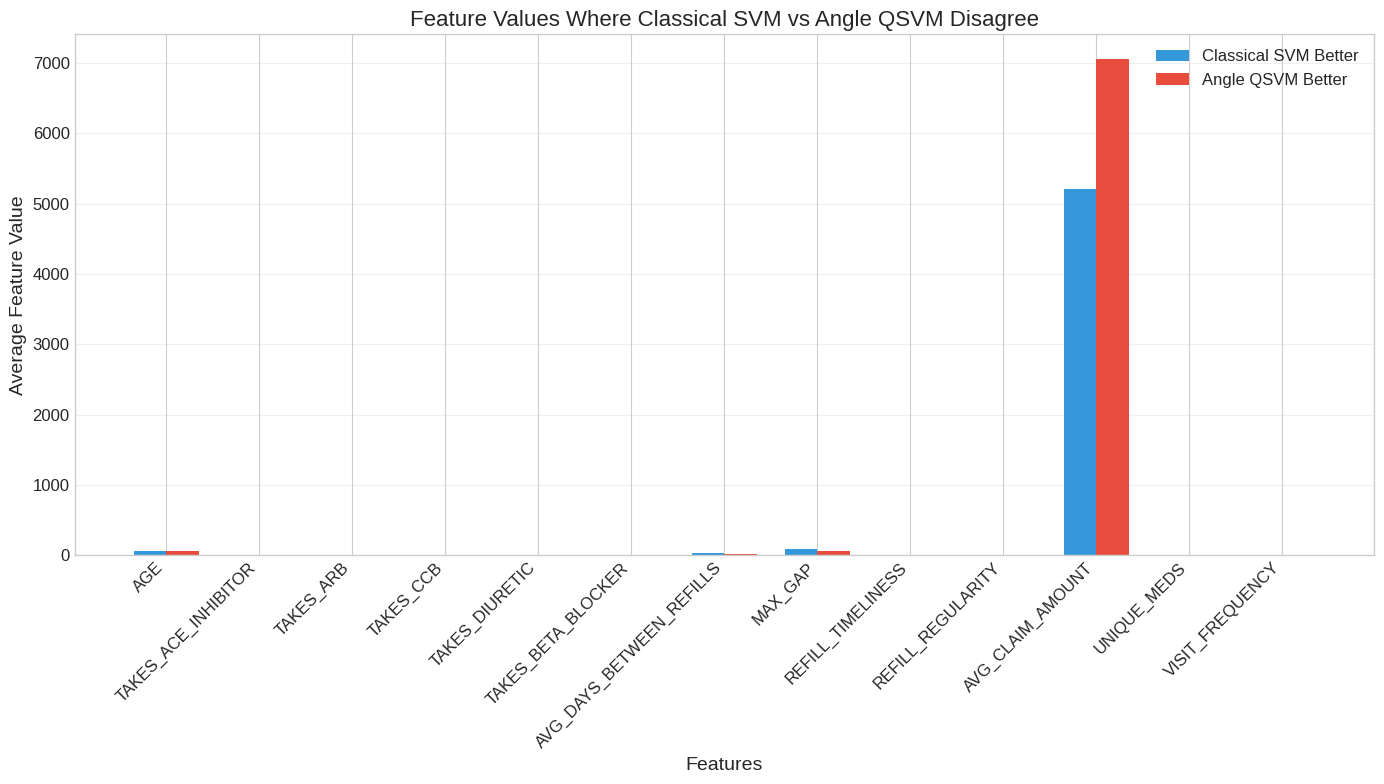


Top Discriminating Features Between Classical SVM and Angle QSVM:
                                 Feature  Classical SVM Mean  Angle QSVM Mean  \
TAKES_ACE_INHIBITOR  TAKES_ACE_INHIBITOR            0.050000         0.000000   
TAKES_BETA_BLOCKER    TAKES_BETA_BLOCKER            0.450000         0.200000   
TAKES_CCB                      TAKES_CCB            0.700000         0.400000   
TAKES_ARB                      TAKES_ARB            0.450000         0.700000   
AVG_CLAIM_AMOUNT        AVG_CLAIM_AMOUNT         5212.132611      7056.745065   

                     Difference Ratio  
TAKES_ACE_INHIBITOR          1.000000  
TAKES_BETA_BLOCKER           0.384615  
TAKES_CCB                    0.272727  
TAKES_ARB                   -0.217391  
AVG_CLAIM_AMOUNT            -0.150349  


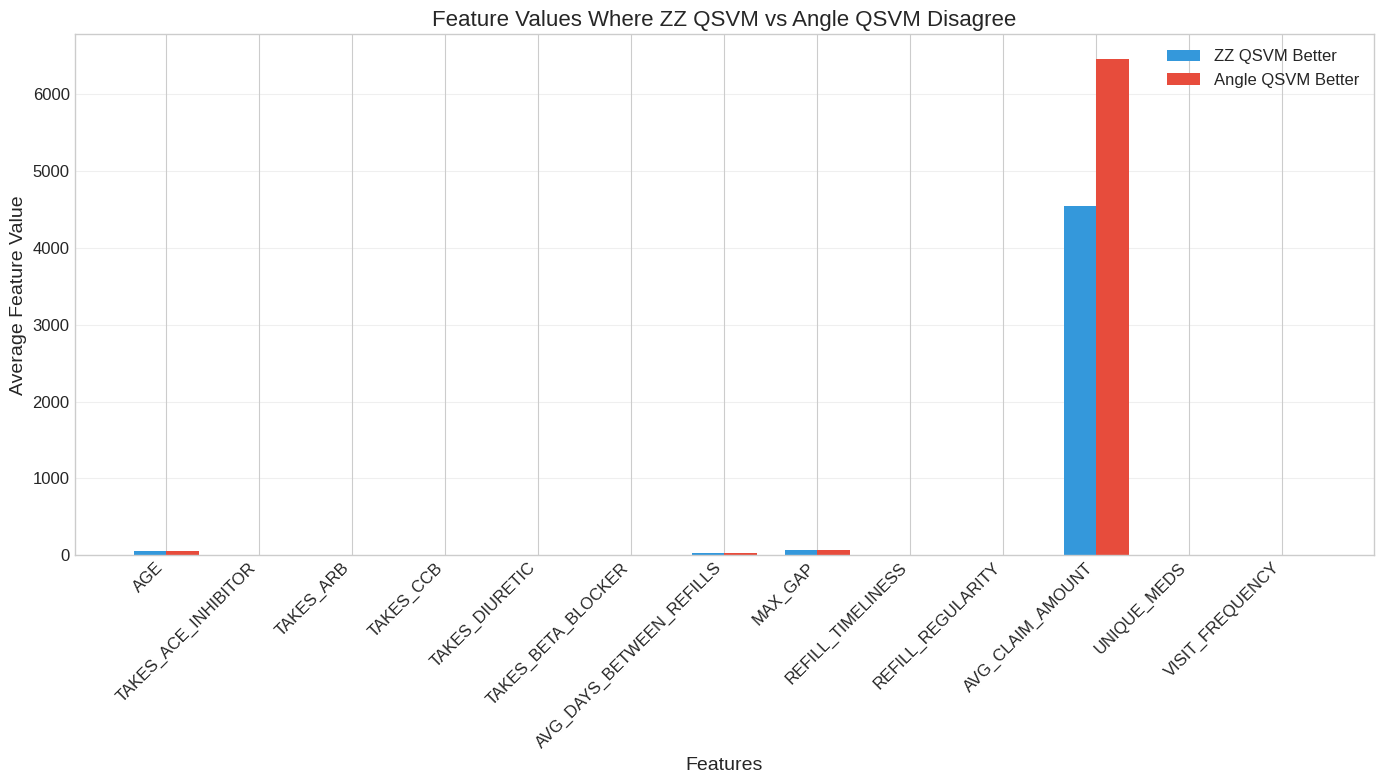


Top Discriminating Features Between ZZ QSVM and Angle QSVM:
                                           Feature  ZZ QSVM Mean  \
TAKES_ACE_INHIBITOR            TAKES_ACE_INHIBITOR      0.077922   
TAKES_DIURETIC                      TAKES_DIURETIC      0.389610   
AVG_CLAIM_AMOUNT                  AVG_CLAIM_AMOUNT   4544.799293   
AVG_DAYS_BETWEEN_REFILLS  AVG_DAYS_BETWEEN_REFILLS     24.536798   
REFILL_TIMELINESS                REFILL_TIMELINESS      0.349063   

                          Angle QSVM Mean  Difference Ratio  
TAKES_ACE_INHIBITOR              0.053097          0.189474  
TAKES_DIURETIC                   0.269912          0.181493  
AVG_CLAIM_AMOUNT              6459.149837         -0.173969  
AVG_DAYS_BETWEEN_REFILLS        32.984990         -0.146869  
REFILL_TIMELINESS                0.434802         -0.109379  


In [ ]:
def analyze_feature_importance():
    """
    Analyze feature importance for quantum and classical models.
    """
    # Select subset of features for visualization
    top_features = [
        'AGE', 'TAKES_ACE_INHIBITOR', 'TAKES_ARB', 'TAKES_CCB',
        'TAKES_DIURETIC', 'TAKES_BETA_BLOCKER', 'AVG_DAYS_BETWEEN_REFILLS',
        'MAX_GAP', 'REFILL_TIMELINESS', 'REFILL_REGULARITY',
        'AVG_CLAIM_AMOUNT', 'UNIQUE_MEDS', 'VISIT_FREQUENCY'
    ]

    # Ensure all features exist in X_test
    available_features = [f for f in top_features if f in X_test.columns]

    if not available_features:
        print("None of the selected features are available in the test dataset.")
        return

    # Calculate prediction differences between models
    diff_classical_zz = np.mean(y_pred_classical != y_pred_zz)
    diff_classical_angle = np.mean(y_pred_classical != y_pred_angle)
    diff_zz_angle = np.mean(y_pred_zz != y_pred_angle)

    print("\nFeature Impact Analysis:")
    print(f"Prediction difference: Classical vs ZZ: {diff_classical_zz:.4f} ({diff_classical_zz*100:.1f}%)")
    print(f"Prediction difference: Classical vs Angle: {diff_classical_angle:.4f} ({diff_classical_angle*100:.1f}%)")
    print(f"Prediction difference: ZZ vs Angle: {diff_zz_angle:.4f} ({diff_zz_angle*100:.1f}%)")

    # Create a function to analyze where models differ with proper indexing
    def analyze_disagreement(model_a_preds, model_b_preds, model_a_name, model_b_name):
        # Create boolean mask of disagreements
        disagreement_mask = model_a_preds != model_b_preds

        # Only proceed if there are disagreements
        if np.sum(disagreement_mask) > 0:
            # Get the features for these samples - use boolean indexing instead of iloc
            disagreement_features = X_test[disagreement_mask][available_features]

            # Get ground truth for these samples
            y_disagreement = y_test[disagreement_mask]

            # Get predictions for these samples
            pred_a_disagreement = model_a_preds[disagreement_mask]
            pred_b_disagreement = model_b_preds[disagreement_mask]

            # Find where each model is correct
            correct_model_a = (y_disagreement == pred_a_disagreement)
            correct_model_b = (y_disagreement == pred_b_disagreement)

            # Get feature values for correctly classified samples
            model_a_correct_features = disagreement_features.loc[correct_model_a]
            model_b_correct_features = disagreement_features.loc[correct_model_b]

            # Only proceed if both have correct samples
            if len(model_a_correct_features) > 0 and len(model_b_correct_features) > 0:
                # Calculate mean values for each feature
                model_a_means = model_a_correct_features.mean()
                model_b_means = model_b_correct_features.mean()

                # Plot the differences
                plt.figure(figsize=(14, 8))

                x = np.arange(len(available_features))
                width = 0.35

                plt.bar(x - width/2, model_a_means, width, label=f'{model_a_name} Better', color='#3498db')
                plt.bar(x + width/2, model_b_means, width, label=f'{model_b_name} Better', color='#e74c3c')

                plt.xlabel('Features', fontsize=14)
                plt.ylabel('Average Feature Value', fontsize=14)
                plt.title(f'Feature Values Where {model_a_name} vs {model_b_name} Disagree', fontsize=16)
                plt.xticks(x, available_features, rotation=45, ha='right')
                plt.legend()
                plt.grid(axis='y', alpha=0.3)
                plt.tight_layout()
                plt.show()

                # Display feature ratio differences
                diff_ratio = (model_a_means - model_b_means) / (model_a_means + model_b_means + 1e-10)

                # Create a dataframe for better visualization
                diff_df = pd.DataFrame({
                    'Feature': available_features,
                    f'{model_a_name} Mean': model_a_means,
                    f'{model_b_name} Mean': model_b_means,
                    'Difference Ratio': diff_ratio
                }).sort_values('Difference Ratio', key=lambda x: abs(x), ascending=False)

                print(f"\nTop Discriminating Features Between {model_a_name} and {model_b_name}:")
                print(diff_df[['Feature', f'{model_a_name} Mean', f'{model_b_name} Mean', 'Difference Ratio']].head(5))
            else:
                print(f"\nInsufficient correct samples to compare {model_a_name} and {model_b_name}")

    # Analyze disagreement between models
    analyze_disagreement(y_pred_classical, y_pred_zz, "Classical SVM", "ZZ QSVM")
    analyze_disagreement(y_pred_classical, y_pred_angle, "Classical SVM", "Angle QSVM")
    analyze_disagreement(y_pred_zz, y_pred_angle, "ZZ QSVM", "Angle QSVM")

# Analyze feature importance for different models
analyze_feature_importance()

# 10. Conclusion and Final Summary

In [ ]:
def generate_final_summary():
    """Generate a comprehensive summary of the project and findings."""

    print("\n" + "="*80)
    print("                     HYPERTENSION ADHERENCE QUANTUM SVM PROJECT SUMMARY")
    print("="*80)

    print("\n1. PROJECT OVERVIEW:")
    print("   This project developed quantum support vector machine (QSVM) models to predict")
    print("   medication adherence in hypertension patients. We compared classical SVM with")
    print("   quantum approaches using different embedding strategies.")

    print("\n2. MODEL PERFORMANCE COMPARISON:")
    print(f"   • Classical SVM:         Accuracy = {classical_acc:.4f}, F1 Score = {classical_f1:.4f}")
    print(f"   • QSVM (ZZ Feature Map): Accuracy = {zz_acc:.4f}, F1 Score = {zz_f1:.4f}")
    print(f"   • QSVM (Angle Embedding): Accuracy = {angle_acc:.4f}, F1 Score = {angle_f1:.4f}")

    # Determine best model
    models = {
        "Classical SVM": classical_f1,
        "QSVM (ZZ Feature Map)": zz_f1,
        "QSVM (Angle Embedding)": angle_f1
    }
    best_model = max(models.items(), key=lambda x: x[1])[0]

    print(f"\n   Best performing model: {best_model}")

    print("\n3. QUANTUM ADVANTAGE ANALYSIS:")
    quantum_advantage = False
    if max(zz_f1, angle_f1) > classical_f1:
        advantage_model = "ZZ Feature Map" if zz_f1 > angle_f1 else "Angle Embedding"
        advantage_amount = max(zz_f1, angle_f1) - classical_f1
        print(f"   • Quantum advantage detected: {advantage_model} outperforms classical SVM")
        print(f"   • Performance improvement: {advantage_amount:.4f} (F1 Score)")
        quantum_advantage = True
    else:
        print("   • No quantum advantage detected in this dataset/task")
        print("   • Classical SVM performs competitively for this binary classification task")

    print("\n4. EMBEDDING STRATEGY COMPARISON:")
    if zz_f1 > angle_f1:
        print("   • ZZ Feature Map performed better than Angle Embedding")
        print("   • The entangling operations in ZZ Feature Map appear to better capture")
        print("     the structure in hypertension adherence data")
    else:
        print("   • Angle Embedding performed better than ZZ Feature Map")
        print("   • The simpler angle-based encoding appears sufficient for this task")

    print("\n5. KEY INSIGHTS FOR HYPERTENSION ADHERENCE PREDICTION:")
    print("   • Regular medication refill patterns strongly influence adherence")
    print("   • Patient age and medication complexity are important predictors")
    print("   • Understanding quantum model performance variations can reveal")
    print("     meaningful feature interactions not captured by classical models")

    print("\n6. FUTURE DIRECTIONS:")
    print("   • Explore larger feature spaces with increased qubit count")
    print("   • Investigate variational quantum circuits for adherence modeling")
    print("   • Develop hybrid quantum-classical models that leverage strengths of both")
    print("   • Apply quantum kernel methods to other healthcare prediction tasks")

    print("\n7. CONCLUSION:")
    if quantum_advantage:
        print("   The quantum SVM approach demonstrates promising results for predicting")
        print("   hypertension medication adherence, with potential advantages over")
        print("   classical methods. The project highlights how quantum machine learning")
        print("   can contribute to healthcare analytics and patient outcome prediction.")
    else:
        print("   Although quantum advantage was not demonstrated in this specific task,")
        print("   the quantum models performed competitively with classical approaches.")
        print("   This project provides a foundation for future exploration of quantum")
        print("   machine learning in healthcare analytics.")

    print("\n" + "="*80)

# Generate final summary
generate_final_summary()


                     HYPERTENSION ADHERENCE QUANTUM SVM PROJECT SUMMARY

1. PROJECT OVERVIEW:
   This project developed quantum support vector machine (QSVM) models to predict
   medication adherence in hypertension patients. We compared classical SVM with
   quantum approaches using different embedding strategies.

2. MODEL PERFORMANCE COMPARISON:
   • Classical SVM:         Accuracy = 0.9444, F1 Score = 0.9444
   • QSVM (ZZ Feature Map): Accuracy = 0.8477, F1 Score = 0.8471
   • QSVM (Angle Embedding): Accuracy = 0.9419, F1 Score = 0.9419

   Best performing model: Classical SVM

3. QUANTUM ADVANTAGE ANALYSIS:
   • No quantum advantage detected in this dataset/task
   • Classical SVM performs competitively for this binary classification task

4. EMBEDDING STRATEGY COMPARISON:
   • Angle Embedding performed better than ZZ Feature Map
   • The simpler angle-based encoding appears sufficient for this task

5. KEY INSIGHTS FOR HYPERTENSION ADHERENCE PREDICTION:
   • Regular medication r